#**Limpieza de datos para el proyecto DBCoders**

Se realizará una limpieza de los Datasets elegidos:
- Databases including Global Competence variables were uploaded in October 2020 - Student questionnaire data files --> https://webfs.oecd.org/pisa2018/SAS_STU_QQQ.zip

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split



In [ ]:
# Defino el directorio en el que voy a trabajar
%mkdir /content/dataset
%cd /content/dataset/

WORK_DIR = os.getcwd()



mkdir: cannot create directory ‘/content/dataset’: File exists
/content/dataset


In [ ]:
! wget https://webfs.oecd.org/pisa2018/SAS_STU_QQQ.zip -O - | gsutil cp - //$WORK_DIR/data.zip

--2023-04-10 13:58:23--  https://webfs.oecd.org/pisa2018/SAS_STU_QQQ.zip
Resolving webfs.oecd.org (webfs.oecd.org)... 78.41.128.150
Connecting to webfs.oecd.org (webfs.oecd.org)|78.41.128.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611425317 (583M) [application/x-zip-compressed]
Saving to: ‘STDOUT’

-                     0%[                    ]  39.76K  52.4KB/s               Copying from <STDIN>...
-                   100%[===================>] 583.10M  1.76MB/s    in 7m 3s   

2023-04-10 14:05:27 (1.38 MB/s) - written to stdout [611425317/611425317]

/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


In [ ]:
! ls /$WORK_DIR/data.zip

//content/dataset/data.zip


Voy a expandir los datos para poder revisar las columnas y el tamaño del dataset con el cuestionario -->

In [ ]:
! unzip /$WORK_DIR/data.zip

Archive:  //content/dataset/data.zip
   creating: STU/
  inflating: STU/CY07MSU_FMT_STU_QQQ.CPT  
  inflating: STU/CY07MSU_FMT_STU_QQQ.SAS7BCAT  
  inflating: STU/CY07MSU_STU_QQQ.FORMAT.SAS  
  inflating: STU/cy07_msu_stu_qqq.sas7bdat  
  inflating: STU/Read Me.txt         


Cambio el nombre del folder para guardar los datos como questionnaire -->

In [ ]:
mv /$WORK_DIR/STU/ /$WORK_DIR/QUESTIONNAIRE/

In [ ]:
%cd /$WORK_DIR/QUESTIONNAIRE/

QUESTIONNAIRE_DIR = os.getcwd()

/content/dataset/QUESTIONNAIRE


Reviso el Read Me del cuestionario -->

In [ ]:
!cat /$QUESTIONNAIRE_DIR/Read*

/*
                Place transport file (.cpt) in the location with the related data files.
                Delete 32-bit format file (.sas7bcat) provided. 
                Running code below on a machine running SAS (64-bit).
                Do this for each format file.
*/

/* Location of transport (.cpt) file */
%let location = C:\User\Location; 

/* Desired name of format file (.sas7bcat) */
%let name = CY07_MS_FMT_STU_QQQ; 

/*******************************************/
libname loc "&location.";  
filename trans "&location.\&name..cpt";  

proc cimport infile=trans lib=loc;
run;


In [ ]:
! ls /$QUESTIONNAIRE_DIR/cy07_msu_stu_qqq.sas7bdat  

//content/dataset/QUESTIONNAIRE/cy07_msu_stu_qqq.sas7bdat


Instalo las librerías para leer ficheros tipo sas --> 

In [ ]:
!pip install pyreadstat
!pip install sas7bdat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sas7bdat: filename=sas7bdat-2.2.3-py3-none-any.whl size=16309 sha256=4030f7e96189f7bb63f8d8cd2c8ab21c719ee3747ea8be49440953a70e539381
  Stored in directory: /root/.cache/pip/wheels/82/f9/33/931c5d927f24f5f5975e1a853d14a2d74f154fa514528b8adb
Successfully built sas7bdat


Voy a convertir los ficheros a CSV, pues es demasiada información para procesar todo el dataset en la memoria disponible. Así que una vez cambiado a CSV, puedo importar únicamente los valores para el país que he elegido (España) -->

In [ ]:
from sas7bdat import SAS7BDAT

#cognitive_dataset = f"{COGNITIVE_DIR}/cy07_msu_stu_cog.sas7bdat"
questionnaire_dataset = f"{QUESTIONNAIRE_DIR}/cy07_msu_stu_qqq.sas7bdat"

#!sas7bdat_to_csv /content/dataset/COG/cy07_msu_stu_cog.sas7bdat /content/dataset/cognitive.csv
!sas7bdat_to_csv /content/dataset/QUESTIONNAIRE/cy07_msu_stu_qqq.sas7bdat /content/dataset/questionnaire.csv

[cy07_msu_stu_cog.sas7bdat] 16.5% complete
[cy07_msu_stu_cog.sas7bdat] 33.0% complete
[cy07_msu_stu_cog.sas7bdat] 49.5% complete
[cy07_msu_stu_cog.sas7bdat] 65.9% complete
[cy07_msu_stu_cog.sas7bdat] 82.4% complete
[cy07_msu_stu_cog.sas7bdat] 98.9% complete
[cy07_msu_stu_cog.sas7bdat] ⟶ [cognitive.csv] wrote 606627 of 606627 lines

Successfully converted 1 of 1 file
[cy07_msu_stu_qqq.sas7bdat] 16.3% complete
[cy07_msu_stu_qqq.sas7bdat] 32.7% complete
[cy07_msu_stu_qqq.sas7bdat] 49.0% complete
[cy07_msu_stu_qqq.sas7bdat] 65.4% complete
[cy07_msu_stu_qqq.sas7bdat] 81.7% complete
[cy07_msu_stu_qqq.sas7bdat] 98.0% complete
[cy07_msu_stu_qqq.sas7bdat] ⟶ [questionnaire.csv] wrote 612004 of 612004 lines

Successfully converted 1 of 1 file


Filtro el fichero questionnaire.csv para generar un dataframe de España --> 

In [ ]:
import pandas as pd

questionnaire_csv = f"{WORK_DIR}/questionnaire.csv"
chunksize = 10000

# Iterar sobre cada "chunk" y filtrar donde CNT == 'ESP'
df_filtered_chunks = []
for chunk in pd.read_csv(questionnaire_csv, chunksize=chunksize):
    filtered_chunk = chunk[chunk['CNT'] == 'ESP']
    df_filtered_chunks.append(filtered_chunk)

# Concatenar cada chunkConcatenate all the filtered chunks into a single dataframe
df_questionnaire = pd.concat(df_filtered_chunks)

Guardo df_questionnaire.csv

In [ ]:
df_questionnaire.to_csv(f"{WORK_DIR}/df_questionnaire.csv")

Ahora, vamos a analizar el dataframe df_questionnaire -->

In [ ]:
print("Shape de df_questionnaire:", df_questionnaire.shape)


Shape de df_questionnaire: (35943, 1119)


¿Cuántos NAN tengo por cada columna del Dataframe? -->

In [ ]:
nan_count = df_questionnaire.isna().sum()
nan_percentage = (nan_count / len(df_questionnaire)) * 100

nan_df = pd.DataFrame({'NaN totales': nan_count, 'NaN %': nan_percentage})
print(nan_df)


          NaN totales  NaN %
CNTRYID             0    0.0
CNT                 0    0.0
CNTSCHID            0    0.0
CNTSTUID            0    0.0
CYC                 0    0.0
...               ...    ...
PV9RTML             0    0.0
PV10RTML            0    0.0
SENWT               0    0.0
VER_DAT             0    0.0
i                   0    0.0

[1119 rows x 2 columns]


Busquemos columnas redundantes. Vamos a iterar entre las columnas del dataframe si solo tiene un valor único. Si es así, se agregará a redundant_columns. -->

In [ ]:
redundant_columns = []
list_columns = df_questionnaire.columns.values

for column in list_columns:
    unique_values = df_questionnaire[column].nunique()
    if unique_values == 1:
        redundant_columns.append(column)

print("Columnas redundantes:", redundant_columns)


Columnas redundantes: ['CNTRYID', 'CNT', 'CYC', 'NatCen', 'SUBNATIO', 'OECD', 'ADMINMODE', 'ST003D03T', 'i']


¿Cuántos valores únicos tengo por columna? 

In [ ]:
# Filter columns based on number of unique values
unique_values_per_column = df_questionnaire.loc[:, df_questionnaire.nunique() > 1000].columns

print("Número de valores únicos superiores 1000 por columna:")
print(unique_values_per_column)


Número de valores únicos superiores 1000 por columna:
Index(['CNTSCHID', 'CNTSTUID', 'STUBMI', 'ESCS', 'HOMEPOS', 'WEALTH',
       'DISCLIMA', 'JOYREAD', 'RESILIENCE', 'GCSELFEFF',
       ...
       'PV2RTML', 'PV3RTML', 'PV4RTML', 'PV5RTML', 'PV6RTML', 'PV7RTML',
       'PV8RTML', 'PV9RTML', 'PV10RTML', 'SENWT'],
      dtype='object', length=200)


Voy a generar la lista de columnas -->

In [ ]:
lista_columnas = df_questionnaire.columns.values

Voy a guardar la información en un Bucket para guardar este dataset y poder trabajarlo desde este punto -->

In [ ]:
! gcloud config unset project

Unset property [core/project].


**---- INICIAMOS AQUÍ CONEXIÓN CON EL BUCKET ---**

In [ ]:
PROJECT_ID = "second-casing-363316" #@param {type:"string"}
! gcloud config set project $PROJECT_ID

Updated property [core/project].


In [ ]:
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

In [ ]:
BUCKET_NAME = "bucket-bdcoders" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

In [ ]:
!gcloud auth login


You are running on a Google Compute Engine virtual machine.
It is recommended that you use service accounts for authentication.

You can run:

  $ gcloud config set account `ACCOUNT`

to switch accounts if necessary.

Your credentials may be visible to others with access to this
virtual machine. Are you sure you want to authenticate with
your personal account?

Do you want to continue (Y/n)?  Y

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=v8wRF2kZFBVx40qhWjwgk

In [ ]:
! gsutil ls -al gs://$BUCKET_NAME

     99405  2023-04-10T14:20:22Z  gs://bucket-bdcoders/Columnas_Descripcion.csv#1681136422359322  metageneration=1
    102769  2023-04-09T17:04:09Z  gs://bucket-bdcoders/descriptions.csv#1681059849532510  metageneration=1
 113634776  2023-04-09T16:59:33Z  gs://bucket-bdcoders/df_clean.csv#1681059573279582  metageneration=1
 146800640  2023-04-04T10:14:51Z  gs://bucket-bdcoders/df_questionnaire.csv#1680603291961950  metageneration=1
2441851383  2023-04-03T22:03:12Z  gs://bucket-bdcoders/questionnaire.csv#1680559392359647  metageneration=1
                                 gs://bucket-bdcoders/DROPOUT/
                                 gs://bucket-bdcoders/XY/
TOTAL: 5 objects, 2702488973 bytes (2.52 GiB)


# ** ** Si estás retomando el trabajo desde el bucket, PASA AL SIGUIENTE PASO ** -->  **

In [ ]:
! gsutil cp $WORK_DIR/Columnas_Descripcion.csv gs://$BUCKET_NAME/Columnas_Descripcion.csv

Copying file:///content/dataset/Columnas_Descripcion.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/97.1 KiB.                                     


In [ ]:
! gsutil cp $WORK_DIR/df_questionnaire.csv gs://$BUCKET_NAME/df_questionnaire.csv

Copying file:///content/dataset/df_questionnaire.csv [Content-Type=text/csv]...
/
Operation completed over 1 objects/140.0 MiB.                                    


In [ ]:
! gsutil ls gs://$BUCKET_NAME/

gs://bucket-bdcoders/Columnas_Descripcion.csv
gs://bucket-bdcoders/descriptions.csv
gs://bucket-bdcoders/df_clean.csv
gs://bucket-bdcoders/df_questionnaire.csv
gs://bucket-bdcoders/questionnaire.csv


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# ** PASO 2. Una vez conectado inicio desde aquí !!! ** 

Vuelvo a definir WORK_DIR --> 

In [ ]:
import os

# Defino el directorio en el que voy a trabajar
%mkdir /content/dataset
%cd /content/dataset/

WORK_DIR = os.getcwd()

/content/dataset


Bajo la df_questionnaire.csv del Bucket --> 


In [ ]:
# Bajo el fichero df_questionnaire.csv y lo valido
!gsutil cp gs://bucket-bdcoders/df_questionnaire.csv $WORK_DIR/df_questionnaire.csv

Copying gs://bucket-bdcoders/df_questionnaire.csv...
| [1 files][140.0 MiB/140.0 MiB]                                                
Operation completed over 1 objects/140.0 MiB.                                    


# **INICIO LIMPIEZA DE DATOS AQUÍ **

In [ ]:
import pandas as pd

df_questionnaire = pd.read_csv('/content/dataset/df_questionnaire.csv')

Verifico si hay columnas vacías -->

In [ ]:
blank_columns = []
list_columns = df_questionnaire.columns.values

for column in list_columns:
    if df_questionnaire[column].isna().sum() == len(df_questionnaire):
      blank_columns.append(column)

print("Columnas vacías:", blank_columns)
len(blank_columns)


Columnas vacías: ['LANGTEST_PAQ', 'ST006Q04TA', 'ST008Q04TA', 'ST127Q03TA', 'ST225Q04HA', 'EC150Q10WA', 'PA001Q01TA', 'PA001Q02TA', 'PA001Q03TA', 'PA003Q01TA', 'PA003Q02TA', 'PA003Q03TA', 'PA003Q04HA', 'PA003Q05IA', 'PA003Q06IA', 'PA003Q07IA', 'PA154Q01IA', 'PA154Q02IA', 'PA154Q03IA', 'PA154Q04IA', 'PA154Q05IA', 'PA154Q06IA', 'PA154Q07IA', 'PA154Q08IA', 'PA154Q09IA', 'PA154Q10HA', 'PA155Q01IA', 'PA156Q01HA', 'PA156Q02HA', 'PA156Q03HA', 'PA156Q04HA', 'PA004Q02NA', 'PA004Q03NA', 'PA004Q04NA', 'PA008Q01TA', 'PA008Q02TA', 'PA008Q03TA', 'PA008Q04TA', 'PA008Q05TA', 'PA008Q06NA', 'PA008Q07NA', 'PA008Q08NA', 'PA008Q09NA', 'PA008Q10NA', 'PA009Q01NA', 'PA009Q02NA', 'PA009Q03NA', 'PA009Q04NA', 'PA009Q05NA', 'PA009Q06NA', 'PA009Q07NA', 'PA009Q08NA', 'PA009Q09NA', 'PA009Q10NA', 'PA009Q11NA', 'PA007Q01TA', 'PA007Q02TA', 'PA007Q03TA', 'PA007Q04TA', 'PA007Q05TA', 'PA007Q06TA', 'PA007Q07TA', 'PA007Q09NA', 'PA007Q11NA', 'PA007Q12NA', 'PA007Q13NA', 'PA007Q14NA', 'PA007Q15NA', 'PA005Q01TA', 'PA006Q01TA', 

164

Elimino las columnas vacías --> 

In [ ]:
df_clean=df_questionnaire.drop(blank_columns, axis = 1)

In [ ]:
print(df_questionnaire.shape)
df_clean.shape

(31911, 1120)


(31911, 956)

Ahora vamos a limpiar los NaN. Vamos a analizar primero cuántos hay --> 
nan_count = df_questionnaire.isna().sum()


In [ ]:
nan_count = df_clean.isna().sum()
nan_percentage = (nan_count / len(df_clean)) * 100

nan_df = pd.DataFrame({'NaN totales': nan_count, 'NaN %': nan_percentage})
print(nan_df)

            NaN totales     NaN %
Unnamed: 0            0  0.000000
CNTRYID               0  0.000000
CNT                   0  0.000000
CNTSCHID              0  0.000000
CNTSTUID              0  0.000000
...                 ...       ...
PV9RTML               1  0.003134
PV10RTML              1  0.003134
SENWT                 1  0.003134
VER_DAT               1  0.003134
i                     1  0.003134

[956 rows x 2 columns]


In [ ]:
NaN_columns = []
list_columns = df_clean.columns.values
Percentage = 0.2

for column in list_columns:
    if df_clean[column].isna().sum()/len(df_clean) > Percentage:
      NaN_columns.append(column)

print(f"Columnas con más del {Percentage} de NaN:", NaN_columns)
len(NaN_columns)

Columnas con más del 0.2 de NaN: ['ST021Q01TA', 'ST221Q01HA', 'ST221Q02HA', 'ST221Q03HA', 'ST221Q04HA', 'ST221Q05HA', 'ST221Q06HA', 'ST221Q07HA', 'ST221Q08HA', 'ST221Q09HA', 'ST223Q02HA', 'ST223Q04HA', 'ST223Q05HA', 'ST223Q08HA', 'ST123Q02NA', 'ST123Q03NA', 'ST123Q04NA', 'ST205Q01HA', 'ST205Q02HA', 'ST205Q03HA', 'ST205Q04HA', 'ST059Q01TA', 'ST059Q02TA', 'ST059Q03TA', 'ST059Q04HA', 'ST060Q01NA', 'ST061Q01NA', 'ST062Q01TA', 'ST062Q02TA', 'ST062Q03TA', 'ST038Q03NA', 'ST038Q04NA', 'ST038Q05NA', 'ST038Q06NA', 'ST038Q07NA', 'ST038Q08NA', 'ST207Q01HA', 'ST207Q02HA', 'ST207Q03HA', 'ST207Q04HA', 'ST207Q05HA', 'ST206Q01HA', 'ST206Q02HA', 'ST206Q03HA', 'ST206Q04HA', 'IC010Q02NA', 'IC010Q03TA', 'IC010Q04TA', 'IC010Q05NA', 'IC010Q06NA', 'IC010Q07TA', 'IC010Q08TA', 'IC010Q09NA', 'IC010Q10NA', 'IC010Q11HA', 'IC010Q12HA', 'IC011Q01TA', 'IC011Q02TA', 'IC011Q03TA', 'IC011Q04TA', 'IC011Q05TA', 'IC011Q06TA', 'IC011Q07TA', 'IC011Q08TA', 'IC011Q09TA', 'IC011Q10HA', 'IC013Q01NA', 'IC013Q04NA', 'IC013Q05NA', 

258

Elimino las columnas que tengan más ddel 20% de NAN --> 

In [ ]:
df_clean=df_clean.drop(NaN_columns, axis = 1)

Voy a analizar cuántas columnas me quedan ahora --> 

In [ ]:
df_clean.shape

(31911, 698)

Voy a subir el archivo 'Columnas_Descripcion.csv' que he transformado del Code Book, ubicado en el sitio de datos de OECD - PISA --> 
https://webfs.oecd.org/pisa2018/PISA2018_CODEBOOK.xlsx

In [ ]:
columns_description = pd.read_csv('/content/Columnas_Descripcion.csv')

In [ ]:
columns_description

,NAME,VARLABEL
0,CNTRYID,Country Identifier
1,CNT,Country code 3-character
2,CNTSCHID,Intl. School ID
3,CNTSTUID,Intl. Student ID
4,CYC,PISA Assessment Cycle (2 digits + 2 character ...
...,...,...
1113,PV8RTML,Plausible Value 8 in Text Structure Subscale o...
1114,PV9RTML,Plausible Value 9 in Text Structure Subscale o...
1115,PV10RTML,Plausible Value 10 in Text Structure Subscale ...
1116,SENWT,Senate Weight (sum of 5000 per country)


In [ ]:
descriptions = dict(zip(columns_description.NAME,columns_description.VARLABEL))
descriptions


{'CNTRYID': 'Country Identifier',
 'CNT': 'Country code 3-character',
 'CNTSCHID': 'Intl. School ID',
 'CNTSTUID': 'Intl. Student ID',
 'CYC': 'PISA Assessment Cycle (2 digits + 2 character Assessment type - MS/FT)',
 'NatCen': 'National Centre 6-digit Code',
 'STRATUM': 'Stratum ID 7-character (cnt + region ID + original stratum ID)',
 'SUBNATIO': 'Adjudicated sub-region code 7-digit code (3-digit country code + region ID + stratum ID)',
 'OECD': 'OECD country',
 'ADMINMODE': 'Mode of Respondent',
 'LANGTEST_QQQ': 'Language of Questionnaire',
 'LANGTEST_COG': 'Language of Assessment',
 'LANGTEST_PAQ': 'Language of Assessment (PAQ)',
 'BOOKID': 'Form Identifier',
 'ST001D01T': 'Student International Grade (Derived)',
 'ST003D02T': 'Student (Standardized) Birth - Month',
 'ST003D03T': 'Student (Standardized) Birth -Year',
 'ST004D01T': 'Student (Standardized) Gender',
 'ST005Q01TA': 'What is the <highest level of schooling> completed by your mother?',
 'ST006Q01TA': 'Does your mother ha

Ahora voy a analizar cuáles son las columnas que tienen información numérica y cuáles son variables categóricas. 

In [ ]:
cat_cols = []
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        cat_cols.append(col)

print ('Las variables categóricas son --> ',cat_cols)

Las variables categóricas son -->  ['CNT', 'CYC', 'STRATUM', 'VER_DAT']


¿Qué son esas variables categóricas? 

In [ ]:
print('Las descripción de las columnas con variables categóricas es \n') 
for col in cat_cols:
    if col in descriptions:
      print(f'{col} ---> {descriptions[col]}\n' )

Las descripción de las columnas con variables categóricas es 

CNT ---> Country code 3-character

CYC ---> PISA Assessment Cycle (2 digits + 2 character Assessment type - MS/FT)

STRATUM ---> Stratum ID 7-character (cnt + region ID + original stratum ID)

VER_DAT ---> Date of the database creation



Son etiquetas de identificación, se pueden eliminar todas!

In [ ]:
df_clean=df_clean.drop(cat_cols, axis = 1)

En total, hasta el momento el dataframe tiene este shape --> 

In [ ]:
df_clean.shape

(31911, 694)

Voy a guardar hasta aquí el dataframe limpio y el dataframe con las descripciones --> 


In [ ]:
df_clean.to_csv(f"{WORK_DIR}/df_clean.csv")

In [ ]:
columns_description.to_csv(f"{WORK_DIR}/descriptions.csv")

Ahora subo al bucket el dataframe limpio y el diccionario con las descripciones --> 

In [ ]:
! gsutil cp $WORK_DIR/df_clean.csv gs://$BUCKET_NAME/df_clean.csv

Copying file:///content/dataset/df_clean.csv [Content-Type=text/csv]...
- [1 files][108.4 MiB/108.4 MiB]                                                
Operation completed over 1 objects/108.4 MiB.                                    


In [ ]:
! gsutil cp $WORK_DIR/descriptions.csv gs://$BUCKET_NAME/descriptions.csv

Copying file:///content/dataset/descriptions.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/100.4 KiB.                                    


## ** 3. Continuo con la limpieza de datos. ¡¡Puedo reiniciar aquí!! **
Vuelvo a cargar el dataframe y las descripciones --> 


In [ ]:
! gsutil ls gs://$BUCKET_NAME/ ## Verifico el nombre y ruta de los ficheros

gs://bucket-bdcoders/descriptions.csv
gs://bucket-bdcoders/df_clean.csv
gs://bucket-bdcoders/df_questionnaire.csv
gs://bucket-bdcoders/questionnaire.csv


In [ ]:
# Defino el directorio en el que voy a trabajar
#%mkdir /content/dataset
%cd /content/dataset/

WORK_DIR = os.getcwd()


/content/dataset


In [ ]:
# Bajo el fichero df_clean.csv y el de descriptions
!gsutil cp gs://bucket-bdcoders/df_clean.csv $WORK_DIR/df_clean.csv
!gsutil cp gs://bucket-bdcoders/descriptions.csv $WORK_DIR/descriptions.csv
!gsutil cp gs://bucket-bdcoders/Columnas_Descripcion.csv $WORK_DIR/Columnas_Descripcion.csv

Copying gs://bucket-bdcoders/df_clean.csv...
\ [1 files][108.4 MiB/108.4 MiB]                                                
Operation completed over 1 objects/108.4 MiB.                                    
Copying gs://bucket-bdcoders/descriptions.csv...
- [1 files][100.4 KiB/100.4 KiB]                                                
Operation completed over 1 objects/100.4 KiB.                                    
Copying gs://bucket-bdcoders/Columnas_Descripcion.csv...
/ [1 files][ 97.1 KiB/ 97.1 KiB]                                                
Operation completed over 1 objects/97.1 KiB.                                     


In [ ]:
#Genero los dataframe -->
descriptions = pd.read_csv(f'{WORK_DIR}/descriptions.csv', index_col = 0)
#descriptions = dict(zip(columns_description.NAME,columns_description.VARLABEL))
df_clean = pd.read_csv(f'{WORK_DIR}/df_clean.csv')
df_clean.shape

(31911, 695)

In [ ]:
columns_description = pd.read_csv(f'{WORK_DIR}/Columnas_Descripcion.csv')
descriptions = dict(zip(columns_description.NAME,columns_description.VARLABEL))

In [ ]:
descriptions

{'CNTRYID': 'Country Identifier',
 'CNT': 'Country code 3-character',
 'CNTSCHID': 'Intl. School ID',
 'CNTSTUID': 'Intl. Student ID',
 'CYC': 'PISA Assessment Cycle (2 digits + 2 character Assessment type - MS/FT)',
 'NatCen': 'National Centre 6-digit Code',
 'STRATUM': 'Stratum ID 7-character (cnt + region ID + original stratum ID)',
 'SUBNATIO': 'Adjudicated sub-region code 7-digit code (3-digit country code + region ID + stratum ID)',
 'OECD': 'OECD country',
 'ADMINMODE': 'Mode of Respondent',
 'LANGTEST_QQQ': 'Language of Questionnaire',
 'LANGTEST_COG': 'Language of Assessment',
 'LANGTEST_PAQ': 'Language of Assessment (PAQ)',
 'BOOKID': 'Form Identifier',
 'ST001D01T': 'Student International Grade (Derived)',
 'ST003D02T': 'Student (Standardized) Birth - Month',
 'ST003D03T': 'Student (Standardized) Birth -Year',
 'ST004D01T': 'Student (Standardized) Gender',
 'ST005Q01TA': 'What is the <highest level of schooling> completed by your mother?',
 'ST006Q01TA': 'Does your mother ha

## * Análisis para determinar la variable dependiente 'y' *

Proponemos trabajar dos dataframes para definir nuestra 'y': 

- Resultado de las pruebas PISA
- Intención de continuar con los estudios

#**Análisis de los resultados de las Pruebas PISA. **

PISA evalúa en base a valores plausibles ("Plausible Values" o PV en adelante). Un Plausible Value no es el puntaje logrado por un estudiante, sino más bien el valor del rango de puntaje en el que se agrupa. 

Hay 90 PV's por cada sección medida en PISA en los siguientes rubros:
- Matemáticas
- Lectura
- Ciencia 
- Competencias Globales 
- Procesos cognitivos 
  - Lectura - Localizar información
  - Lectura - Comprensión 
  - Lectura - Evaluar y Reflexionar 
  - Lectura - Un documento 
  - Lectura - Múltiples documentos

En PISA, cada estudiante recibe 5 PV's para cada escala y subescala de la prueba.

El dataset tiene 90 columnas de PV (lo que implica un grupo de resultados). Vamos a analizar primero cómo está la información. Para esto tomaremos 3 estudiantes al azar y veremos los resultados que tiene en sus valores plausibles. 

In [ ]:
#Vamos a iniciar formando el grupo de columnas que inician por PV 
# Primero genero una lista con las columnas que empiezan con PV
pv_columns = [col for col in df_clean.columns if col.startswith('PV')]

# Ahora imprimo el número de columnas y la lista
print(f"Número de columnas que empiezan con 'PV': {len(pv_columns)}")
print(pv_columns)

Número de columnas que empiezan con 'PV': 90
['PV1MATH', 'PV2MATH', 'PV3MATH', 'PV4MATH', 'PV5MATH', 'PV6MATH', 'PV7MATH', 'PV8MATH', 'PV9MATH', 'PV10MATH', 'PV1READ', 'PV2READ', 'PV3READ', 'PV4READ', 'PV5READ', 'PV6READ', 'PV7READ', 'PV8READ', 'PV9READ', 'PV10READ', 'PV1SCIE', 'PV2SCIE', 'PV3SCIE', 'PV4SCIE', 'PV5SCIE', 'PV6SCIE', 'PV7SCIE', 'PV8SCIE', 'PV9SCIE', 'PV10SCIE', 'PV1GLCM', 'PV2GLCM', 'PV3GLCM', 'PV4GLCM', 'PV5GLCM', 'PV6GLCM', 'PV7GLCM', 'PV8GLCM', 'PV9GLCM', 'PV10GLCM', 'PV1RCLI', 'PV2RCLI', 'PV3RCLI', 'PV4RCLI', 'PV5RCLI', 'PV6RCLI', 'PV7RCLI', 'PV8RCLI', 'PV9RCLI', 'PV10RCLI', 'PV1RCUN', 'PV2RCUN', 'PV3RCUN', 'PV4RCUN', 'PV5RCUN', 'PV6RCUN', 'PV7RCUN', 'PV8RCUN', 'PV9RCUN', 'PV10RCUN', 'PV1RCER', 'PV2RCER', 'PV3RCER', 'PV4RCER', 'PV5RCER', 'PV6RCER', 'PV7RCER', 'PV8RCER', 'PV9RCER', 'PV10RCER', 'PV1RTSN', 'PV2RTSN', 'PV3RTSN', 'PV4RTSN', 'PV5RTSN', 'PV6RTSN', 'PV7RTSN', 'PV8RTSN', 'PV9RTSN', 'PV10RTSN', 'PV1RTML', 'PV2RTML', 'PV3RTML', 'PV4RTML', 'PV5RTML', 'PV6RTML', 

In [ ]:
#Ahora eligiremos 3 filas de forma aleatoria para ver qué valores tiene en cada columna:

random_rows = df_clean[pv_columns].sample(n=3)

# Muestro los valores
print(random_rows.T)

            31591    12166    19045
PV1MATH   414.993  555.284  300.450
PV2MATH   468.530  552.969  360.259
PV3MATH   486.914  552.550  278.066
PV4MATH   488.610  589.936  245.441
PV5MATH   516.303  530.850  262.707
...           ...      ...      ...
PV6RTML   522.377  523.684  278.336
PV7RTML   475.232  535.092  322.429
PV8RTML   458.644  527.728  237.321
PV9RTML   502.241  529.325  283.406
PV10RTML  527.083  539.240  272.055

[90 rows x 3 columns]


Todas las columnas tienen un valor. 

Ahora, voy a verificar si hay NaN o '0' en alguna columna PV:

In [ ]:
# Genero un dataframe únicamente de los PV para analizarlos
df_pv = df_clean[pv_columns]

# Verifico si hay NaN
nan_count = df_pv.isna().sum().sum()
print(f"El número total de NaN es: {nan_count}")

# Ahora haré lo mismo para '0'
zero_count = (df_pv == 0).sum().sum()
print(f"El total de '0' en las columnas 'PV' es: {zero_count}")

# Validamos si existe algún valor '0' o NaN
has_nan_or_zero = df_pv.isna().any().any() or (df_pv == 0).any().any()
print(f"¿Hay algún NaN o 0 en las columnas PV? {has_nan_or_zero}")

El número total de NaN es: 48
El total de '0' en las columnas 'PV' es: 0
¿Hay algún NaN o 0 en las columnas PV? True


Existen 48 NaN en el dataset. ¿Cuántos estudiantes (CNTSTUID) tienen valores NaN en sus PV?

In [ ]:
# Encontrar las filas que tienen valores NaN
rows_with_nan = df_pv.isna().any(axis=1)

# Mostrar el valor CNTSTUID en las filas con valores NaN
cntstuid_values = df_clean.loc[rows_with_nan, 'CNTSTUID']
print(cntstuid_values)

31910    72441032.0
Name: CNTSTUID, dtype: float64


Solo hay un estudiante con NaN en el dataset. Voy a eliminar la fila. 

In [ ]:
# Vuelvo a seleccionar las filas con valores NaN en los PV
rows_with_nan = df_pv.isna().any(axis=1)

# Genero un dataframe sin NaN en columnas PV
df_clean_no_nan = df_clean[~rows_with_nan]


# Cómo queda el shape del dataframe comparado con el original?
print("El shape del dataframe origingal es ", df_clean.shape)
print("El shape del dataframe sin NaN en columnas PV es ",df_clean_no_nan.shape)

El shape del dataframe origingal es  (31911, 695)
El shape del dataframe sin NaN en columnas PV es  (31910, 695)


In [ ]:
df_clean = df_clean_no_nan

Para estimar 'y', vamos a hacer un promedio de todos los resultados obtenidos y lo colocaremos en una nueva columna llamada 'PISA_SCORE_AV'

In [ ]:
# Calculo el promedio de los resultados PV de todos los alumnos 
df_clean['PISA_SCORE_AV'] = df_clean[pv_columns].mean(axis=1)

# Valido que existe la columna y el valor --> 
print(df_clean.PISA_SCORE_AV.head(3))

0    579.944911
1    453.119411
2    554.780400
Name: PISA_SCORE_AV, dtype: float64


¿Cuáles son los valores máximos y mínimos de 'PISA_SCORE_AV'?

In [ ]:
print("El valor máximo de 'PISA_SCORE_AV' es -->", df_clean.PISA_SCORE_AV.max())
print("El valor mínimo de 'PISA SCORE AV' es -->", df_clean.PISA_SCORE_AV.min())

El valor máximo de 'PISA_SCORE_AV' es --> 742.3947777777776
El valor mínimo de 'PISA SCORE AV' es --> 207.1996555555556


Voy a definir los "outliers" como los valores que queden a dos desviaciones estándar de la media. 

¿Tengo 'outliers'?

In [ ]:
# Calculo los Z-scores
z_scores = stats.zscore(df_clean['PISA_SCORE_AV'])

# Defino los límites para definir la frontera con los outliers en base a la desviación estándar
threshold = 2

# Identifico los outliers
outliers_down = df_clean[(z_scores < -threshold)]
outliers_up = df_clean[(z_scores > threshold)]
outliers = outliers_up + outliers_down

# Imprimo outliers
print(len(outliers.PISA_SCORE_AV))
outliers.shape

1297


(1297, 696)

Vamos a visualizar un poco los datos, para ver su comportamiento.

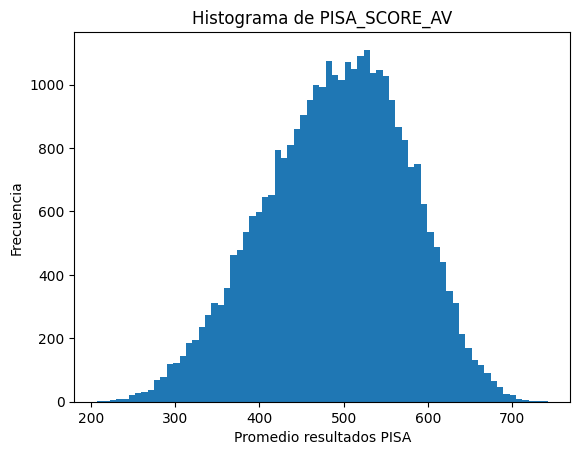

In [ ]:
import matplotlib.pyplot as plt

data = df_clean['PISA_SCORE_AV']
plt.hist(data, bins='auto')
plt.title('Histograma de PISA_SCORE_AV')
plt.xlabel('Promedio resultados PISA')
plt.ylabel('Frecuencia')
plt.show()


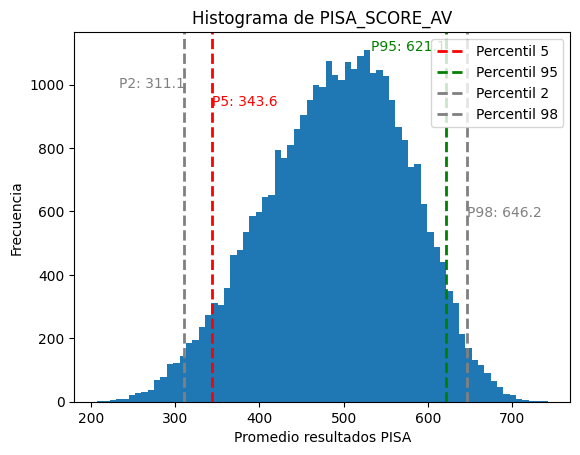

In [ ]:
# Calcular los percentiles 5 y 95
lower_limit = np.percentile(data, 5)
upper_limit = np.percentile(data, 95)
lower_limit_96 = np.percentile(data,2)
upper_limit_96 = np.percentile(data,98)

# Crear el histograma
plt.hist(data, bins='auto')
plt.title('Histograma de PISA_SCORE_AV')
plt.xlabel('Promedio resultados PISA')
plt.ylabel('Frecuencia')

# Agregar líneas verticales para los percentiles 5 y 95, también 2 y 98.
plt.axvline(lower_limit, color='red', linestyle='dashed', linewidth=2, label='Percentil 5')
plt.axvline(upper_limit, color='green', linestyle='dashed', linewidth=2, label='Percentil 95')
plt.axvline(lower_limit_96, color='grey', linestyle='dashed', linewidth=2, label='Percentil 2')
plt.axvline(upper_limit_96, color='grey', linestyle='dashed', linewidth=2, label='Percentil 98')

# Agregar etiquetas de texto con los valores límite
plt.text(lower_limit, plt.gca().get_ylim()[1] * 0.8, f'P5: {lower_limit:.1f}', fontsize=10, color='red', ha='left')
plt.text(upper_limit, plt.gca().get_ylim()[1] * 0.95, f'P95: {upper_limit:.1f}', fontsize=10, color='green', ha='right')
plt.text(lower_limit_96, plt.gca().get_ylim()[1] * 0.85, f'P2: {lower_limit_96:.1f}', fontsize=10, color='grey', ha='right')
plt.text(upper_limit_96, plt.gca().get_ylim()[1] * 0.5, f'P98: {upper_limit_96:.1f}', fontsize=10, color='grey', ha='left')

# Agregar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


Los datos tienen un comportamiento cercano a GAUSS, con una asimetría positiva (un poco ladeado hacia la derecha). Parece que hay una mayor dispersión de resultados abajo de la media, mientras que arriba de la media se ven más compactos. El hecho de que exista una mayor dispersión a la izquierda sugiere que los datos en la parte izquierda del gráfico están más "separados". Este tipo de distribución puede ser el resultado de múltiples factores o procesos que influyen en tus datos.


También, se observa que el 90% de los resultados se agrupan entre 343 y 621 puntos. El pico de la curva se ve aplanado, por lo que es una distribución multimodal, hay varios resultados con frecuencias altas. No tenemos una moda única. 

Los valores más bajos llegan hasta poco más de 200, mientras que los más altos, se aproximan a 750. 

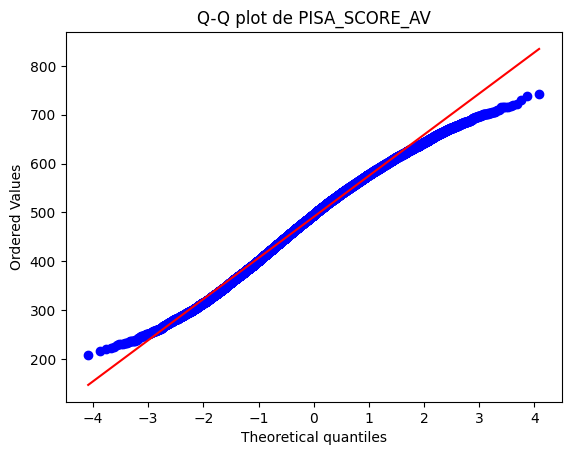

In [ ]:
data = df_clean['PISA_SCORE_AV']
stats.probplot(data, dist='norm', plot=plt)
plt.title('Q-Q plot de PISA_SCORE_AV')
plt.show()

Vamos a analizar los posibles outliers con dos desviaciones estándar. La gráfica no es perfectamente normal, pero es muy similar, por lo que tendríamos aproximadamente el 96% de los datos incluidos. 

In [ ]:
print(f'El porcentaje de los outliers arriba de {threshold} la desviación estándar, es {100*len(outliers_up.PISA_SCORE_AV)/len(df_clean)}%')
print(f'El porcentaje de los outliers abajo de {threshold} la desviación estándar, es {100*len(outliers_down.PISA_SCORE_AV)/len(df_clean)}%')

El porcentaje de los outliers arriba de 2 la desviación estándar, es 1.206518332811031%
El porcentaje de los outliers abajo de 2 la desviación estándar, es 2.8580382325289877%


¿Serán outliers? Hay más datos que quedan fuera en la parte de abajo que en la parte de arriba de los límites propuestos. 

Queremos estudiar los que obtienen menores resultados. Vamos a dejarlos, a ver cómo se comportan. 

Además, no se notan estudiantes con resultados disparatados en los extremos, parece una continuación de la gráfica. 

Analizaremos la correlación de todas las variables vs PISA_SCORE_AV (excepto las de los 'Plausible Values').

In [ ]:
# Establezco el límite para definir si las correlaciones son buenas
threshold = 0.35

# Genero el dataset sin las columnas PV
non_pv_columns = [col for col in df_clean.columns if col not in pv_columns and col != 'PISA_SCORE_AV']

# Calculamos la correlación con PISA_SCORE_AV
correlation = df_clean[non_pv_columns].corrwith(df_clean['PISA_SCORE_AV'])


# Filtro las variables con alta correlación en base al límite determinado
lower_threshold = -(threshold)
strong_correlations = correlation[(correlation > threshold) | (correlation < lower_threshold)]

# Muestro las correlaciones
print(strong_correlations)

ST001D01T     0.521159
ST013Q01TA    0.399153
ST127Q01TA   -0.424016
ST127Q02TA   -0.443571
ST163Q02HA   -0.370641
ST163Q03HA   -0.369658
ST225Q03HA    0.384048
ST225Q06HA    0.472528
ST196Q02HA    0.368797
IC152Q06HA    0.353069
GRADE         0.521159
REPEAT       -0.534115
BSMJ          0.373637
METASUM       0.411813
METASPAM      0.449180
SCREADCOMP    0.369953
PISADIFF     -0.410975
dtype: float64


Vamos a generar una comparación para ver las columnas que se añaden entre los distintos 'threshold' y evaluar nuestras decisiones. 

In [ ]:
# Establezco el límite para definir si las correlaciones son buenas
threshold_2 = 0.35

# Genero el dataset sin las columnas PV
non_pv_columns = [col for col in df_clean.columns if col not in pv_columns and col != 'PISA_SCORE_AV']

# Calculamos la correlación con PISA_SCORE_AV
correlation = df_clean[non_pv_columns].corrwith(df_clean['PISA_SCORE_AV'])


# Filtro las variables con alta correlación en base al límite determinado
lower_threshold_2 = -(threshold_2)
strong_correlations_2 = correlation[(correlation > threshold_2) | (correlation < lower_threshold_2)]

# Muestro las correlaciones
print(strong_correlations_2)

ST001D01T     0.521159
ST013Q01TA    0.399153
ST127Q01TA   -0.424016
ST127Q02TA   -0.443571
ST163Q02HA   -0.370641
ST163Q03HA   -0.369658
ST225Q03HA    0.384048
ST225Q06HA    0.472528
ST196Q02HA    0.368797
IC152Q06HA    0.353069
GRADE         0.521159
REPEAT       -0.534115
BSMJ          0.373637
METASUM       0.411813
METASPAM      0.449180
SCREADCOMP    0.369953
PISADIFF     -0.410975
dtype: float64


In [ ]:
# Selecciona elementos de 'strong_correlations_2' que no están en 'strong_correlations'
only_in_strong_correlations = strong_correlations[~strong_correlations.isin(strong_correlations_2)]

print(only_in_strong_correlations)

Series([], dtype: float64)


In [ ]:
# Hago una lista con las variables con alta correlación
only_in_strong_correlations_list = only_in_strong_correlations.index.get_level_values(0).tolist()

# Imprimo sus descripciones
for col in only_in_strong_correlations_list:
  print(f"{col} --> {descriptions[col]}")

¿Cuántas variables muestran una correlación en base a la solicitada? 

In [ ]:
print(f"Hay {len(strong_correlations)} variables con una correlación superior a {threshold}.") # Número de variables con correlación superior al valor planteado 
print(f"Hay {len(strong_correlations_2)} variables con una correlación superior a {threshold_2}.") # Número de variables con correlación superior al valor planteado 

Hay 17 variables con una correlación superior a 0.35.
Hay 17 variables con una correlación superior a 0.35.


¿Qué son esas variables? 

In [ ]:
# Hago una lista con las variables con alta correlación
strong_correlations_list = strong_correlations.index.get_level_values(0).tolist()

# Imprimo sus descripciones
for col in strong_correlations_list:
  print(f"{col} --> {descriptions[col]}")

ST001D01T --> Student International Grade (Derived)
ST013Q01TA --> How many books are there in your home?
ST127Q01TA --> Have you ever repeated a <grade>? At <ISCED 1>
ST127Q02TA --> Have you ever repeated a <grade>? At <ISCED 2>
ST163Q02HA --> In the PISA test, how do you feel about the reading tasks: There were many words I could not understand.
ST163Q03HA --> In the PISA test, how do you feel about the reading tasks: Many texts were too difficult for me.
ST225Q03HA --> Do you expect to complete? <ISCED level 3A>
ST225Q06HA --> Do you expect to complete? <ISCED level 5A or 6>
ST196Q02HA --> How easy to perform on your own: Explain how carbon-dioxide emissions affect global climate change
IC152Q06HA --> Digital device used for learning or teaching during lessons within the last month: Music
GRADE --> Grade compared to modal grade in country
REPEAT --> Grade Repetition
BSMJ --> Students expected occupational status (SEI)
METASUM --> Meta-cognition: summarising
METASPAM --> Meta-cogniti

Llaman la atención algunas variables:
- Existe una alta correlación entre los resultados de la prueba y el hecho de que se haya repetido algún curso en ISCED 1 (Primaria) o ISCED 2 (Secundaria)

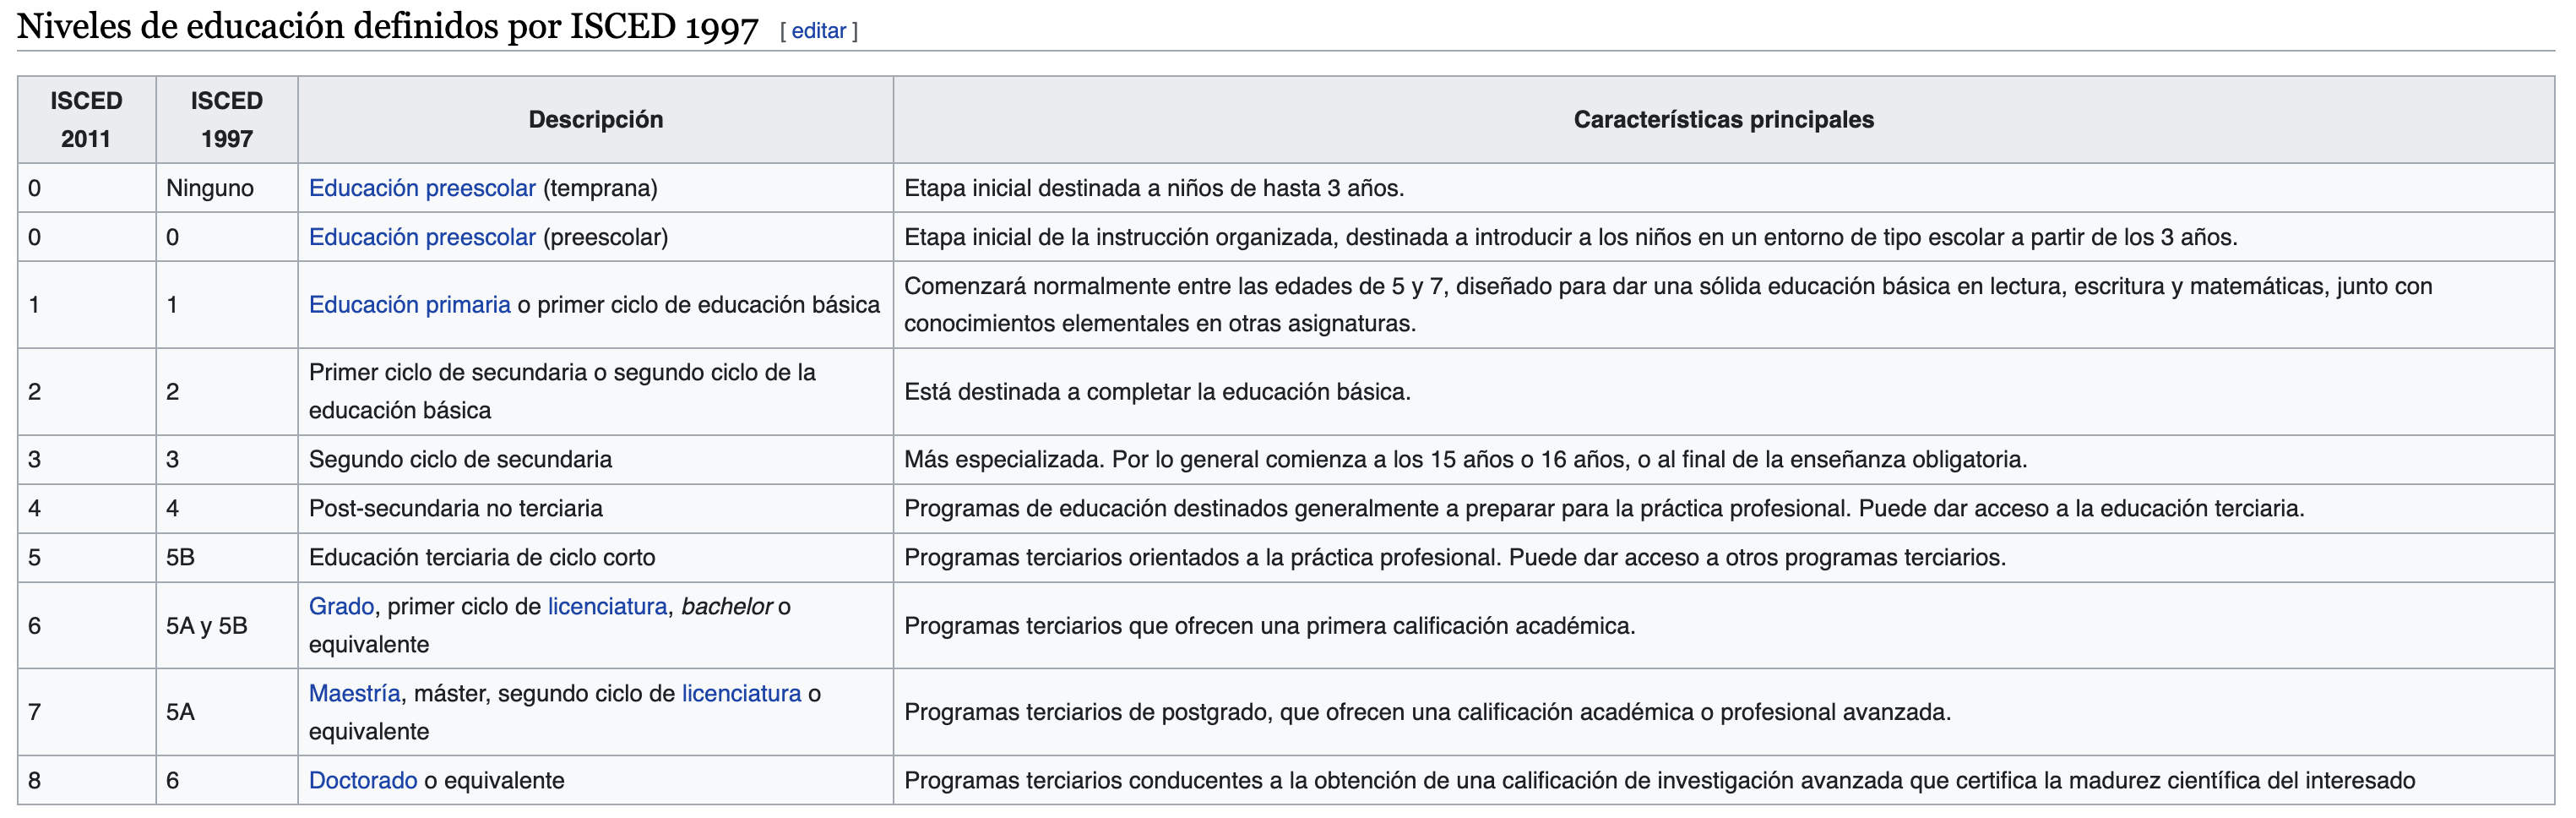


- La habilidad lectura parece ser un factor muy importante, pues seis de las 17 variables están relacionadas con las habilidades lectoras ->
  - ¿Cuántos libros hay en tu casa? 
  - ¿Cómo te sentiste en las tareas relacionadas con la lectura en la prueba PISA? "Habían demasiadas palabras que no entendía"
  - ¿Cómo te sentiste en las tareas relacionadas con la lectura en la prueba PISA? "Muchos textos eran muy difíciles para mí"
  - Meta-cognición: Sumarizar
  - Meta-cognición: Evaluar la credibilidad 
  - Autoconcepto de capacidad lectora: Percepción de la competencia

- La opinión del estudiante sobre el alcance sus estudios tiene un peso importante, aunque diferenciado en dos niveles: 
  - ISCED 3A (Bachillerato) <- Muestra un coeficiente de correlación de 0.38
  - ISCED 5A (Primer ciclo de licencuatura) <- Este tiene una correlación de 0.47, de las más fuertes 




- Existe una correlación de 0.35 cuando se utilizan dispositivos electrónicos para aprender música. 

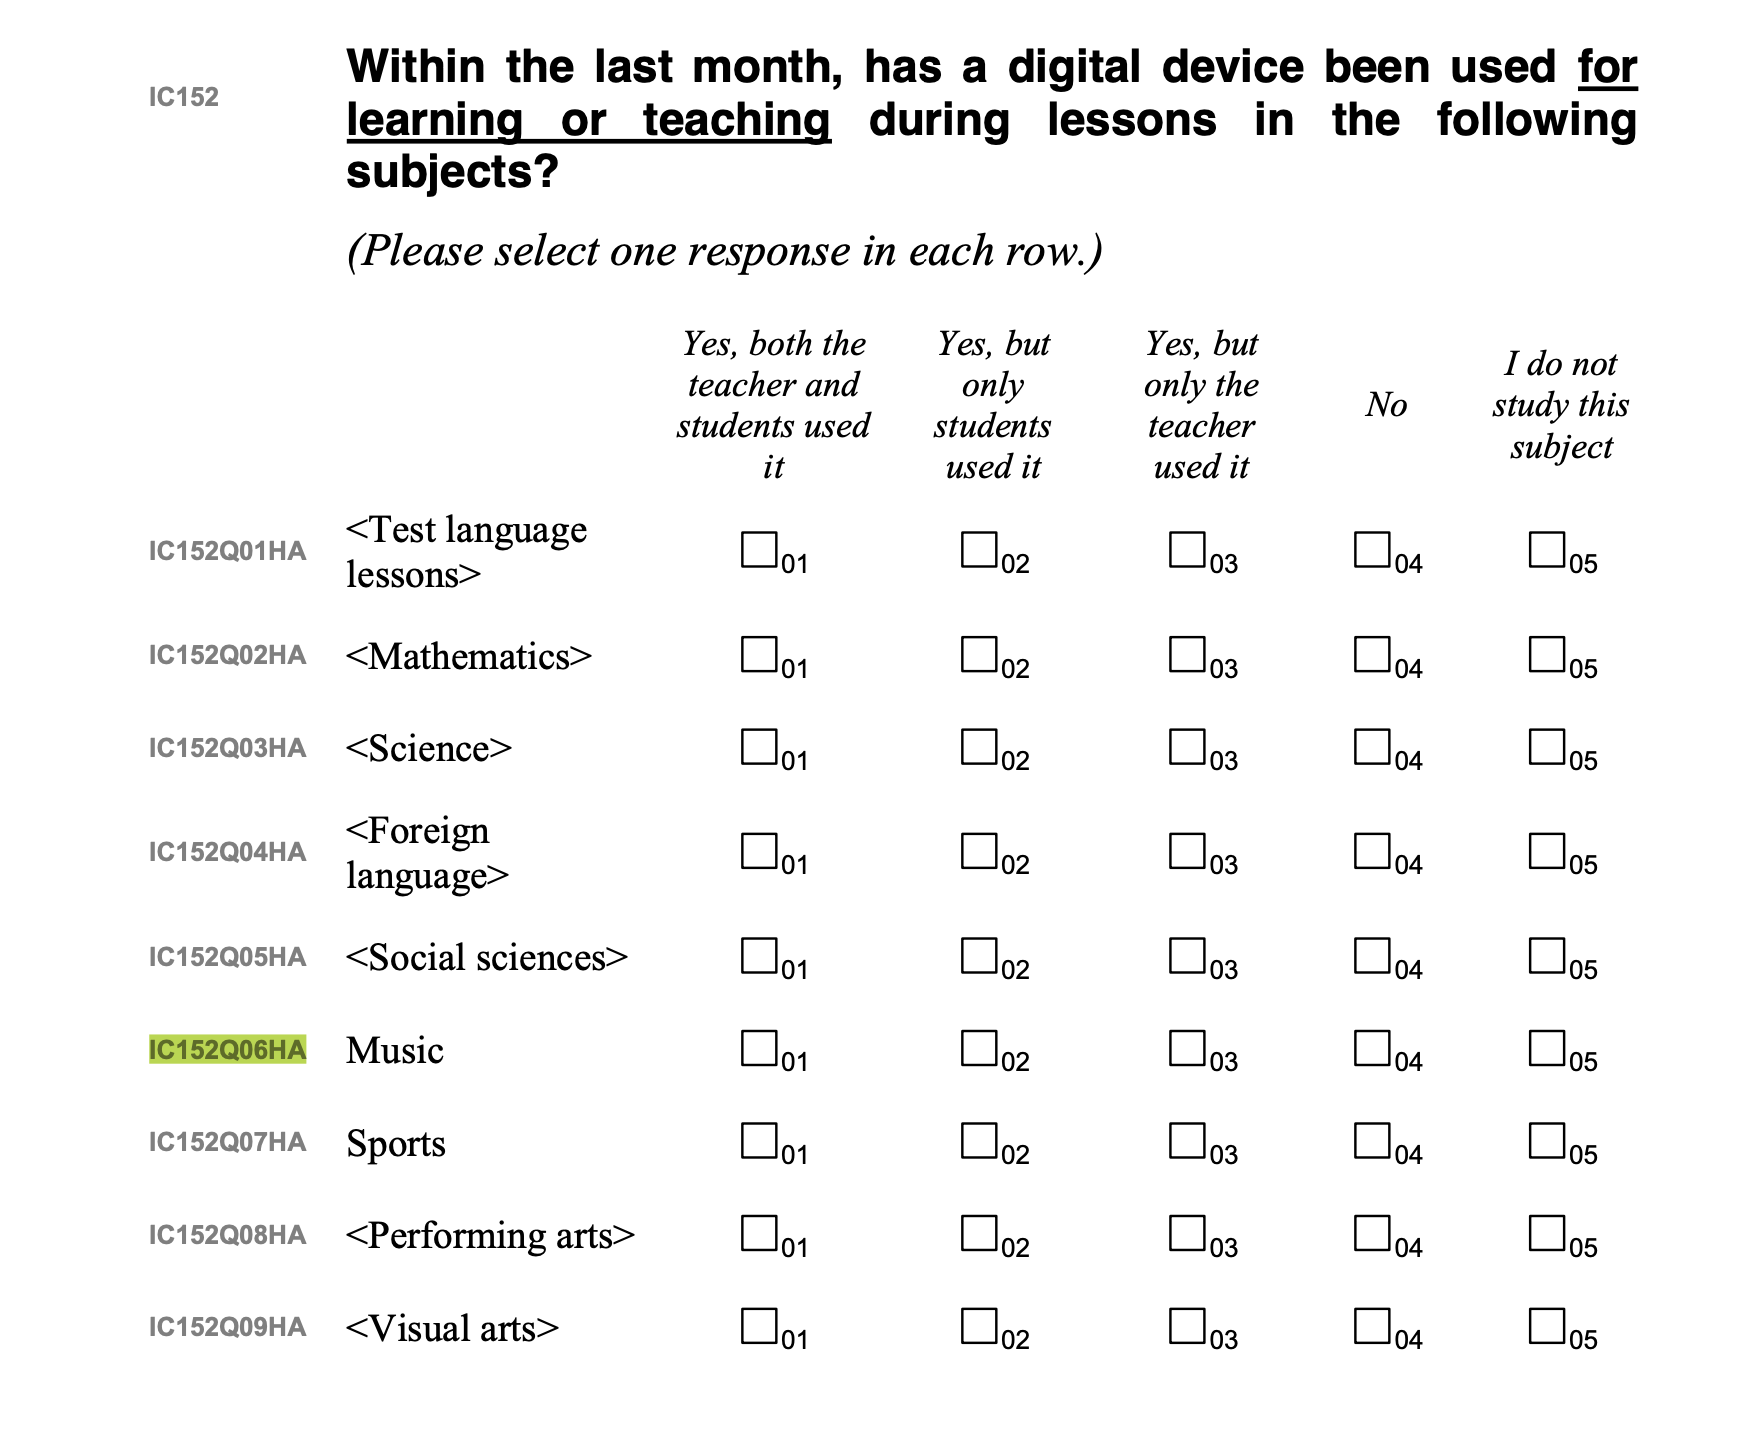

In [ ]:
print("IC152Q06HA tiene los siguientes valores únicos --> ", df_clean.IC152Q06HA.unique())


IC152Q06HA tiene los siguientes valores únicos -->  [ 1.  4.  5. nan  3.  2.]


Voy a analizar todas las variables con fuerte correlación con 'PISA_SCORE_AV' para ver cuántos NaN tengo. 

In [ ]:
for col in strong_correlations_list:
  print(f"El total de NaN en {col} es {df_clean[col].isna().sum()}, de un total de {len(df_clean)} filas")

El total de NaN en ST001D01T es 0, de un total de 31910 filas
El total de NaN en ST013Q01TA es 568, de un total de 31910 filas
El total de NaN en ST127Q01TA es 2224, de un total de 31910 filas
El total de NaN en ST127Q02TA es 1087, de un total de 31910 filas
El total de NaN en ST163Q02HA es 1130, de un total de 31910 filas
El total de NaN en ST163Q03HA es 1189, de un total de 31910 filas
El total de NaN en ST225Q03HA es 733, de un total de 31910 filas
El total de NaN en ST225Q06HA es 733, de un total de 31910 filas
El total de NaN en ST196Q02HA es 3252, de un total de 31910 filas
El total de NaN en IC152Q06HA es 5187, de un total de 31910 filas
El total de NaN en GRADE es 0, de un total de 31910 filas
El total de NaN en REPEAT es 430, de un total de 31910 filas
El total de NaN en BSMJ es 6007, de un total de 31910 filas
El total de NaN en METASUM es 2529, de un total de 31910 filas
El total de NaN en METASPAM es 3246, de un total de 31910 filas
El total de NaN en SCREADCOMP es 1624, de

Voy a ver cuántos estudiantes tienen más NaN en sus datos

In [ ]:
nan_count_df = df_clean.loc[:, strong_correlations_list+['CNTSTUID']] \
                       .groupby('CNTSTUID') \
                       .apply(lambda x: x[strong_correlations_list].isna().sum(axis=1).reset_index(drop=True)) \
                       .reset_index() \
                       .rename(columns={0: 'NaN_count'})

La variable nan_count_df tiene el número de NaN por fila en las columnas con correlación más fuerte con 'PISA_SCORE_AV' --> 

In [ ]:
nan_count_df

,CNTSTUID,NaN_count
0,72400001.0,0
1,72400002.0,1
2,72400003.0,0
3,72400004.0,0
4,72400005.0,1
...,...,...
31905,72441026.0,2
31906,72441027.0,0
31907,72441028.0,0
31908,72441029.0,1


¿Cuántas NaN podemos llegar a tener por columna? 

In [ ]:
nan_count_df['NaN_count'].unique()

array([ 0,  1,  5,  6,  7,  2, 12,  9,  4, 15,  8,  3, 10, 11, 14, 13])

Tengo columnas con hasta 15 valores en NaN

In [ ]:
max_noun_count = nan_count_df['NaN_count'].max()

In [ ]:
max_noun_count

15

¿Cuántas filas tengo por cada cantidad de NaN?

In [ ]:
for i in range (max_noun_count + 1):
  print(f"Hay {nan_count_df['NaN_count'].value_counts()[i]} CNTSTUDIDs que tienen {i} NaN")

Hay 17923 CNTSTUDIDs que tienen 0 NaN
Hay 8903 CNTSTUDIDs que tienen 1 NaN
Hay 2542 CNTSTUDIDs que tienen 2 NaN
Hay 727 CNTSTUDIDs que tienen 3 NaN
Hay 386 CNTSTUDIDs que tienen 4 NaN
Hay 216 CNTSTUDIDs que tienen 5 NaN
Hay 152 CNTSTUDIDs que tienen 6 NaN
Hay 130 CNTSTUDIDs que tienen 7 NaN
Hay 220 CNTSTUDIDs que tienen 8 NaN
Hay 165 CNTSTUDIDs que tienen 9 NaN
Hay 75 CNTSTUDIDs que tienen 10 NaN
Hay 50 CNTSTUDIDs que tienen 11 NaN
Hay 20 CNTSTUDIDs que tienen 12 NaN
Hay 18 CNTSTUDIDs que tienen 13 NaN
Hay 4 CNTSTUDIDs que tienen 14 NaN
Hay 379 CNTSTUDIDs que tienen 15 NaN


Vamos a definir que utilizaremos las filas que tengan al menos 2/3 de las columnas con alta correlación con 'PISA_SCORE_AV' -->

In [ ]:
var_valid = int(len(strong_correlations_list)*2/3)
# Determino las filas que son <= var_valid
rows_to_keep = nan_count_df['NaN_count'] <= var_valid

# Elimino las filas que tienen más columnas que las determinadas en var_valid 
df_clean = df_clean[df_clean['CNTSTUID'].isin(nan_count_df[rows_to_keep]['CNTSTUID'])]

In [ ]:
nan_count_df = df_clean.loc[:, strong_correlations_list+['CNTSTUID']] \
                       .groupby('CNTSTUID') \
                       .apply(lambda x: x[strong_correlations_list].isna().sum(axis=1).reset_index(drop=True)) \
                       .reset_index() \
                       .rename(columns={0: 'NaN_count'})

Valido que las operaciones hayan sido correctas -->

In [ ]:
nan_count_df['NaN_count'].unique()

array([ 0,  1,  5,  6,  7,  2,  9,  4,  8,  3, 10, 11])

In [ ]:
max_noun_count = nan_count_df['NaN_count'].max()

In [ ]:
# Hago una lista con las variables con alta correlación
strong_correlations_list = strong_correlations.index.get_level_values(0).tolist()

# Imprimo sus descripciones
for col in strong_correlations_list:
  print(f"{col} --> {descriptions[col]}")

ST001D01T --> Student International Grade (Derived)
ST013Q01TA --> How many books are there in your home?
ST127Q01TA --> Have you ever repeated a <grade>? At <ISCED 1>
ST127Q02TA --> Have you ever repeated a <grade>? At <ISCED 2>
ST163Q02HA --> In the PISA test, how do you feel about the reading tasks: There were many words I could not understand.
ST163Q03HA --> In the PISA test, how do you feel about the reading tasks: Many texts were too difficult for me.
ST225Q03HA --> Do you expect to complete? <ISCED level 3A>
ST225Q06HA --> Do you expect to complete? <ISCED level 5A or 6>
ST196Q02HA --> How easy to perform on your own: Explain how carbon-dioxide emissions affect global climate change
IC152Q06HA --> Digital device used for learning or teaching during lessons within the last month: Music
GRADE --> Grade compared to modal grade in country
REPEAT --> Grade Repetition
BSMJ --> Students expected occupational status (SEI)
METASUM --> Meta-cognition: summarising
METASPAM --> Meta-cogniti

¿Cómo queda el shape de df_clean?

In [ ]:
df_clean.shape

(31489, 696)

Vamos a a dividir en 'y' y 'X' para train, test y validation

In [ ]:
df_clean.CNTSTUID.isna().sum() # Validamos si hay algún valor con NaN en CNTSTUID

0

In [ ]:
# Generamos el directorio XY --> y = 'PISA_SCORE_AV'
%mkdir /content/XY
%cd /content/XY/

XY_DIR = os.getcwd()

/content/XY


In [ ]:
from sklearn.model_selection import train_test_split

# Dividimos la información en Train, Test y Val
X1_train_val, X1_test, y1_train_val, y1_test = train_test_split(
    df_clean[strong_correlations_list], df_clean['PISA_SCORE_AV'],
    test_size=0.2, random_state=3
)
X1_train, X1_val, y1_train, y1_val = train_test_split(
    X1_train_val, y1_train_val,
    test_size=0.2, random_state=3
)

# Validamos los shapes
print(f"X1_train shape: {X1_train.shape}")
print(f"y1_train shape: {y1_train.shape}")
print(f"X1_val shape: {X1_val.shape}")
print(f"y1_val shape: {y1_val.shape}")
print(f"X1_test shape: {X1_test.shape}")
print(f"y1_test shape: {y1_test.shape}")

# Guardamos en local los sets -->
X1_train.to_csv(f"{XY_DIR}/X1_train.csv")
y1_train.to_csv(f"{XY_DIR}/y1_train.csv")
X1_test.to_csv(f"{XY_DIR}/X1_test.csv")
y1_test.to_csv(f"{XY_DIR}/y1_test.csv")
X1_val.to_csv(f"{XY_DIR}/X1_val.csv")
y1_val.to_csv(f"{XY_DIR}/y1_val.csv")

# Guardamos en el bucket
! gsutil cp $XY_DIR/X1_train.csv gs://$BUCKET_NAME/XY/X1_train.csv
! gsutil cp $XY_DIR/y1_train.csv gs://$BUCKET_NAME/XY/y1_train.csv
! gsutil cp $XY_DIR/X1_test.csv gs://$BUCKET_NAME/XY/X1_test.csv
! gsutil cp $XY_DIR/y1_test.csv gs://$BUCKET_NAME/XY/y1_test.csv
! gsutil cp $XY_DIR/X1_val.csv gs://$BUCKET_NAME/XY/X1_val.csv
! gsutil cp $XY_DIR/y1_val.csv gs://$BUCKET_NAME/XY/y1_val.csv



X1_train shape: (20152, 17)
y1_train shape: (20152,)
X1_val shape: (5039, 17)
y1_val shape: (5039,)
X1_test shape: (6298, 17)
y1_test shape: (6298,)
Copying file:///content/XY/X1_train.csv [Content-Type=text/csv]...
\
Operation completed over 1 objects/1.6 MiB.                                      
Copying file:///content/XY/y1_train.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/464.4 KiB.                                    
Copying file:///content/XY/X1_test.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/507.6 KiB.                                    
Copying file:///content/XY/y1_test.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/145.1 KiB.                                    
Copying file:///content/XY/X1_val.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/406.7 KiB.                                    
Copying file:///content/XY/y1_val.csv [Content-Type=text/csv]...
-
Operation completed over 1 object

#**Interés en terminar los estudios. **

No hemos encontrado una variable en PISA que apunte de manera directa al abandono escolar. El proyecto tiene la posibilidad de unirse a un software de gestión en donde se agregue información en tiempo real a los aprendizajes que emanan de PISA (como pudieran ser actitudes problemáticas, ausentismo, calificaciones bajas, dificultades de aprendizaje, embarazos o problemas en casa). 

**"La UE considera abandono escolar temprano a la tasa de individuos de entre 18 y 24 años con sólo secundaria obligatoria y que no están matriculados en niveles superiores." (Martín, 2007). **

Para este prototipo, hemos elegido las expectativas de logro escolar para la educación primaria, secundaria y la preparatoria para el trabajo o los estudios universitarios: 

- ST225Q01HA --> ISCED nivel 2 (Primer Ciclo de la Secundaria)

- ST225Q02HA --> ISCED nivel 3B o C (Secundaria y primer ciclo formación profesional)

- ST225Q03HA --> ISCED nivel 3A (Secundaria)

- ST225Q04HA --> ISCED nivel 4 (Educación Vocacional - No se usó en España)

- ST225Q05HA --> ISCED nivel 5B (Formación Profesional Superior)

- ST225Q06HA --> ISCED nivel 5A o 6 (Universidad)




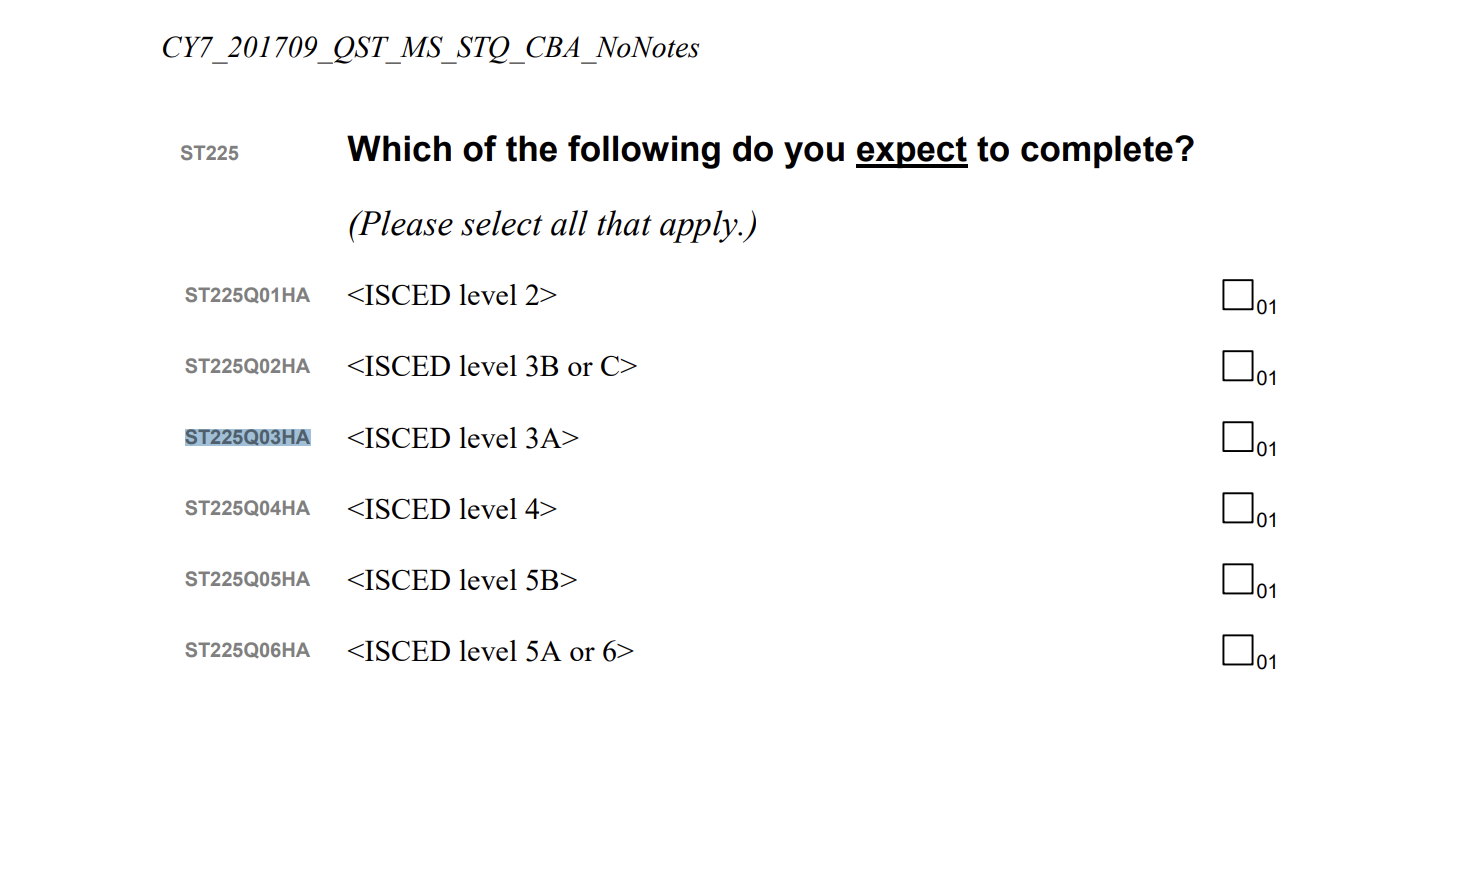

## Definición de 'y' y de X

Definiremos una variable independiente, en base a las respuestas dadas por los estudiantes sobre sus expectativas del nivel educativo que esperan terminar. 

Dado que tenemos varios niveles que pudieran mostrar un riesgo de deserción, hemos decidido dar valores entre 
de la siguiente manera: 


*   Riesgo alto de abandono (2 puntos)
  - Si no se selecciona ninguna opción
  - Si no se selecciona ISCED nivel 2A, 3A, 3B o C (Primer Ciclo Secundaria, Secundaria y primer ciclo formación profesional) o superior
*   Riesgo medio de abandono (1 puntos)
  - Si no se selecciona 5A, 5B o 6
*   Riesgo bajo de deserción (0 puntos)
  - Se da cuando el alumno indica que SI finalizará sus estudios con nivel 5A, 5B o 6





## *Iniciamos bajando el df_clean y descriptions para iniciar el análisis* -->

In [ ]:
# Bajo el fichero df_clean.csv y el de descriptions
!gsutil cp gs://bucket-bdcoders/df_clean.csv $WORK_DIR/df_clean.csv
!gsutil cp gs://bucket-bdcoders/descriptions.csv $WORK_DIR/descriptions.csv
!gsutil cp gs://bucket-bdcoders/Columnas_Descripcion.csv $WORK_DIR/Columnas_Descripcion.csv

Copying gs://bucket-bdcoders/df_clean.csv...
- [1 files][108.4 MiB/108.4 MiB]                                                
Operation completed over 1 objects/108.4 MiB.                                    
Copying gs://bucket-bdcoders/descriptions.csv...
- [1 files][100.4 KiB/100.4 KiB]                                                
Operation completed over 1 objects/100.4 KiB.                                    
Copying gs://bucket-bdcoders/Columnas_Descripcion.csv...
- [1 files][ 97.1 KiB/ 97.1 KiB]                                                
Operation completed over 1 objects/97.1 KiB.                                     


In [ ]:
#Genero los dataframe -->
descriptions = pd.read_csv(f'{WORK_DIR}/descriptions.csv', index_col = 0)
#descriptions = dict(zip(columns_description.NAME,columns_description.VARLABEL))
df_clean = pd.read_csv(f'{WORK_DIR}/df_clean.csv')
df_clean.shape

(31911, 695)

In [ ]:
columns_description = pd.read_csv(f'{WORK_DIR}/Columnas_Descripcion.csv')
descriptions = dict(zip(columns_description.NAME,columns_description.VARLABEL))

Ahora, analizamos las columnas que inicien con ST225Q -->

In [ ]:
# ¿Cuáles son las columnas que inician con ST225Q?
st225q_columns = [col for col in df_clean.columns if col.startswith('ST225Q')]
st225q_columns


['ST225Q01HA', 'ST225Q02HA', 'ST225Q03HA', 'ST225Q05HA', 'ST225Q06HA']

¿Qué valores tiene cada columna? 

In [ ]:
unique_values = {}
for col in st225q_columns:
    unique_values[col] = df_clean[col].unique()
unique_values

{'ST225Q01HA': array([ 1.,  0., nan]),
 'ST225Q02HA': array([ 0.,  1., nan]),
 'ST225Q03HA': array([ 1.,  0., nan]),
 'ST225Q05HA': array([ 0.,  1., nan]),
 'ST225Q06HA': array([ 1.,  0., nan])}

Vemos que tienen NaN, ¿Cuántos son? 

In [ ]:
nan_counts = {}
for col in st225q_columns:
    nan_count = df_clean[col].isna().sum()
    nan_percentage = (nan_count / len(df_clean)) * 100
    nan_counts[col] = {"count": nan_count, "percentage": nan_percentage}

print("Valores únicos:")
for col, values in unique_values.items():
    print(f"{col}: {values}")

print("\nNaN totales y pocentajes:")
for col, stats in nan_counts.items():
    print(f"{col}: total = {stats['count']}, porcentaje = {stats['percentage']}%")


Valores únicos:
ST225Q01HA: [ 1.  0. nan]
ST225Q02HA: [ 0.  1. nan]
ST225Q03HA: [ 1.  0. nan]
ST225Q05HA: [ 0.  1. nan]
ST225Q06HA: [ 1.  0. nan]

NaN totales y pocentajes:
ST225Q01HA: total = 733, porcentaje = 2.29701356898875%
ST225Q02HA: total = 733, porcentaje = 2.29701356898875%
ST225Q03HA: total = 733, porcentaje = 2.29701356898875%
ST225Q05HA: total = 733, porcentaje = 2.29701356898875%
ST225Q06HA: total = 733, porcentaje = 2.29701356898875%


In [ ]:
# Filtramos las filas en donde las variables 'ST225Q' tienen NaN
rows_with_nan = df_clean[df_clean[st225q_columns].isna().any(axis=1)]

# ¿Cuántos estudiantes tienen NaN en sus respuestas 'ST225Q'?
len(rows_with_nan)


733

In [ ]:
# Eliminamos las filas que tengan NaN en 'ST225Q' -->
df_clean = df_clean.dropna(subset=st225q_columns)

In [ ]:
unique_values = {}
for col in st225q_columns:
    unique_values[col] = df_clean[col].unique()
unique_values

{'ST225Q01HA': array([1., 0.]),
 'ST225Q02HA': array([0., 1.]),
 'ST225Q03HA': array([1., 0.]),
 'ST225Q05HA': array([0., 1.]),
 'ST225Q06HA': array([1., 0.])}

In [ ]:
len(df_clean)

31178

Ahora voy a generar una nueva columna, llamada DROPOUT_RISK. En esta pondré los valores de riesgo para cada estudiante (de acuerdo a la política planteada anteriormente) -->

In [ ]:
# Estas son las columnas que indican que el estudiante tiene interés en continuar sus estudios completos 
specific_columns = ['ST225Q05HA', 'ST225Q06HA']
specificLow_columns = ['ST225Q02HA', 'ST225Q03HA']

# Genero una función para calcular el riesgo de abandono ('DROPUT_RISK)
def calculate_dropout_risk(row):
    if not (row[st225q_columns] == 1).any():
        return 2
    elif not (row[specific_columns] == 1).any():
        return 2
    elif not (row[specificLow_columns] == 1).any():
        return 1
    else:
        return 0

# Aplico la función a 'DROPOUT_RISK' 
df_clean['DROPOUT_RISK'] = df_clean.apply(calculate_dropout_risk, axis=1)


In [ ]:
df_clean['DROPOUT_RISK'].unique()

array([0, 2, 1])

In [ ]:
#revisamos la distribución de las respuestas sobre la intención de finalizar estudios
df_clean['DROPOUT_RISK'].value_counts()

0    21535
2     6763
1     2880
Name: DROPOUT_RISK, dtype: int64

Existen varias columnas que buscan normalizar los resultados de las pruebas, de acuerdo a las diferencias entre escuelas y el entorno de los estudiantes (información procesada con SAS). Todas inician con W_FSTUWT. Voy a eliminarlos, pues han metido mucho ruido al ser valores contínuos que más adelante tengo que redondear. También estamos rellenando en el análisis de Chi2 los NaN en base a moda en todas las columnas y estos solo hacen más complicado el proceso, sin que podamos interpretarlos adecuadamente. Es posible que estas variables distorsionen los resultados. -->

In [ ]:
columns_to_drop = [col for col in df_clean.columns if col.startswith("W_FSTUWT")]
df_clean.drop(columns=columns_to_drop, inplace=True)


In [ ]:
fstuwt_columns = [col for col in df_clean.columns if col.startswith('W_FSTUWT')]

print(fstuwt_columns)


[]


Como trabajaré con rangos, necesito validar si no tengo columnas con un solo valor. --> 

In [ ]:
df_clean.drop(columns='i', inplace=True) #Elimino esta columna que tiene valor '31' y no la encuentro en el code book.

KeyError: ignored

In [ ]:
# Evalúo si tengo solo un valor en alguna columna
constant_columns = [col for col in df_clean.columns if df_clean[col].nunique() == 1]

# Imprimo la lista de columnas con un solo valor 
print("Constant columns:")
for col in constant_columns:
  print(f"{col} --> {descriptions[col]}")


Constant columns:
CNTRYID --> Country Identifier
NatCen --> National Centre 6-digit Code
SUBNATIO --> Adjudicated sub-region code 7-digit code (3-digit country code + region ID + stratum ID)
OECD --> OECD country
ADMINMODE --> Mode of Respondent
ST003D03T --> Student (Standardized) Birth -Year


Todas son etiquetas y el año de nacimiento es el mismo, pues todos los estudiantes que asisten a la prueba deben tener 15 años (es el cálculo de la edad). Vamos a eliminarlas -->

In [ ]:
df_clean.drop(columns=constant_columns, inplace=True) #Elimino la lista de columnas en constant_columns

Vamos a analizar cuantos NaN tenemos por columna

In [ ]:
NaN_columns = []
list_columns = df_clean.columns.values
Percentage = 0.1

for column in list_columns:
    if df_clean[column].isna().sum()/len(df_clean) > Percentage:
      NaN_columns.append(column)

print(f"Columnas con más del {Percentage} de NaN:", NaN_columns)
len(NaN_columns)

Columnas con más del 0.1 de NaN: ['ST006Q01TA', 'ST006Q03TA', 'ST008Q01TA', 'ST008Q02TA', 'ST008Q03TA', 'ST215Q01HA', 'ST215Q02HA', 'ST215Q03HA', 'ST215Q04HA', 'ST215Q05HA', 'ST216Q01HA', 'ST216Q02HA', 'ST216Q03HA', 'ST216Q04HA', 'ST216Q05HA', 'ST216Q06HA', 'ST218Q01HA', 'ST218Q02HA', 'ST218Q03HA', 'ST218Q04HA', 'ST218Q05HA', 'ST218Q06HA', 'ST218Q07HA', 'ST222Q01HA', 'ST222Q03HA', 'ST222Q04HA', 'ST222Q05HA', 'ST222Q06HA', 'ST222Q08HA', 'ST222Q09HA', 'ST222Q10HA', 'ST214Q01HA', 'ST214Q02HA', 'ST214Q03HA', 'ST214Q06HA', 'ST220Q01HA', 'ST220Q02HA', 'ST220Q03HA', 'ST220Q04HA', 'ST217Q01HA', 'ST217Q02HA', 'ST217Q03HA', 'ST217Q04HA', 'ST217Q05HA', 'ST219Q01HA', 'ST219Q02HA', 'ST219Q03HA', 'ST219Q04HA', 'ST219Q05HA', 'ST219Q06HA', 'ST204Q02HA', 'ST204Q03HA', 'ST204Q04HA', 'ST204Q05HA', 'ST177Q01HA', 'ST177Q02HA', 'ST177Q03HA', 'ST189Q01HA', 'ST221Q11HA', 'IC009Q03TA', 'IC009Q06NA', 'IC009Q07NA', 'IC009Q09TA', 'IC009Q11NA', 'IC150Q01HA', 'IC150Q02HA', 'IC150Q03HA', 'IC150Q04HA', 'IC150Q05HA', 

176

In [ ]:
df_clean.drop(columns=NaN_columns, inplace=True) #Elimino columnas con más 10% de NaN en NaN_Columns

In [ ]:
df_clean.shape #Comprobamos que se hayan eliminado

(31178, 512)

Ahora obtenemos la correlación entre las variables y 'DROPOUT_RISK'

**MÉTODO SPEARMAN**
- Fortalezas: Aplica para relaciones no lineales, es más robusto para outliers y aplica tanto para variables contínuas como ordinales.
- Debilidades: No aplica para variables categóricas no ordinales y no aplica para relaciones lineales (No es nuestro caso) 

En nuestro caso, las variables enteras y solo pueden tener 3 valores. 

In [ ]:
# Límite correlación
threshold = 0.2

# Generamos una lista de columnas sin 'ST225Q' ni 'DROPOUT_RISK'
non_st225q_columns = [col for col in df_clean.columns if col not in st225q_columns and col != 'DROPOUT_RISK']

# Calculamos la correlación de ranking de Spearman para 'DROPOUT_RISK'
correlation = df_clean[non_st225q_columns].corrwith(df_clean['DROPOUT_RISK'], method='spearman')

# Filtramos las variables que cumplen con el criterio para determinar una alta correlación (Límite correlación)
spearman_correlations = correlation[(correlation > threshold) | (correlation < -threshold)]

# Creamos el spearman_dict con el nombre de las variables y sus correlaciones
spearman_dict = dict(spearman_correlations)

# Imprimo los resultados
for col in spearman_correlations.index:
    print(f"{col}: {spearman_correlations[col]}  --> {descriptions[col]}")

print(len(spearman_correlations))


ST001D01T: -0.28934565367919146  --> Student International Grade (Derived)
ST013Q01TA: -0.20081481076504845  --> How many books are there in your home?
ST127Q01TA: 0.239016931604658  --> Have you ever repeated a <grade>? At <ISCED 1>
ST127Q02TA: 0.24798490435122125  --> Have you ever repeated a <grade>? At <ISCED 2>
GRADE: -0.28934565367919146  --> Grade compared to modal grade in country
REPEAT: 0.28717850326521066  --> Grade Repetition
ESCS: -0.20514608943937515  --> Index of economic, social and cultural status
PV1MATH: -0.28593643955212383  --> Plausible Value 1 in Mathematics
PV2MATH: -0.28558581972147273  --> Plausible Value 2 in Mathematics
PV3MATH: -0.2884668271646307  --> Plausible Value 3 in Mathematics
PV4MATH: -0.28153678940141574  --> Plausible Value 4 in Mathematics
PV5MATH: -0.2805229863824123  --> Plausible Value 5 in Mathematics
PV6MATH: -0.2954198030438814  --> Plausible Value 6 in Mathematics
PV7MATH: -0.2939513454018612  --> Plausible Value 7 in Mathematics
PV8MATH:

**MÉTODO PEARSON**

- Fortalezas: Es fácil de calcular, mide relación lineal entre variables y funciona bien con variables contínuas.
- Debilidades: No detecta relaciones no-lineales.

En nuestro caso, lo estamos tomando como punto de referencia. Tenemos variables ordinales y binarias. 

In [ ]:
# Límite correlación
threshold = 0.2

# Generamos una lista de columnas sin 'ST225Q' ni 'DROPOUT_RISK'
non_st225q_columns = [col for col in df_clean.columns if col not in st225q_columns and col != 'DROPOUT_RISK']

# Calculamos la correlación de ranking de Spearman para 'DROPOUT_RISK'
correlation = df_clean[non_st225q_columns].corrwith(df_clean['DROPOUT_RISK'], method='pearson')

# Filtraamos las variables que cumplen con el criterio para determinar una alta correlación (Límite correlación)
pearson_correlations = correlation[(correlation > threshold) | (correlation < -threshold)]

# Creamos el diccionario pearson_dict con las variables y sus correspondientes correlaciones
pearson_dict = dict(pearson_correlations)

#Imprimo los resultados
for col in pearson_correlations.index:
    print(f"{col}: {pearson_correlations[col]}  --> {descriptions[col]}")

print(len(pearson_correlations))

ST001D01T: -0.31105280792354  --> Student International Grade (Derived)
ST013Q01TA: -0.2106580308768556  --> How many books are there in your home?
ST127Q01TA: 0.25111827782730656  --> Have you ever repeated a <grade>? At <ISCED 1>
ST127Q02TA: 0.2619001898626957  --> Have you ever repeated a <grade>? At <ISCED 2>
GRADE: -0.31105280792353857  --> Grade compared to modal grade in country
REPEAT: 0.301915459057226  --> Grade Repetition
ESCS: -0.22388309018115243  --> Index of economic, social and cultural status
PV1MATH: -0.3081975929065613  --> Plausible Value 1 in Mathematics
PV2MATH: -0.3091886721008971  --> Plausible Value 2 in Mathematics
PV3MATH: -0.30993903806982587  --> Plausible Value 3 in Mathematics
PV4MATH: -0.3033520886583952  --> Plausible Value 4 in Mathematics
PV5MATH: -0.3033799605156405  --> Plausible Value 5 in Mathematics
PV6MATH: -0.317451264634892  --> Plausible Value 6 in Mathematics
PV7MATH: -0.31581033620438254  --> Plausible Value 7 in Mathematics
PV8MATH: -0.312

Dado que hay tres valores posibles en la columna 'DROPOUT_RISK', se valorará utilizando scores de información mútua, para determinar las variables con mayor peso. 

**MÉTODO SCORE DE INFORMACIÓN MÚTUA**

- Fortalezas: Puede capturar relaciones no lineales entre variables, funciona bien con variables contínuas y categóricas.
- Debilidades: Requiere más recursos computacionales.

En nuestro caso, se adecúa de manera muy clara al tipo de variables que tenemos. 

In [ ]:
# Generar lista de columnas sin 'ST225Q', 'DROPOUT_RISK', y sin las que inician con 'W_FSTU'
non_st225q_columns = [col for col in df_clean.columns if col not in st225q_columns and col != 'DROPOUT_RISK' and not col.startswith('W_FSTU')]

# Rellenar los NaN con la moda
df_clean_filled = df_clean.fillna(df_clean.mode().iloc[0])

# Calcular los scores de información mútua para 'DROPOUT_RISK'
mutual_info_scores = mutual_info_classif(df_clean_filled[non_st225q_columns], df_clean_filled['DROPOUT_RISK'])

# Crear el diccionario de las columnas y los scores
mi_dict = dict(zip(non_st225q_columns, mutual_info_scores))

# Ordenar la información del diccionario de manera descendente
sorted_mi_dict = {k: v for k, v in sorted(mi_dict.items(), key=lambda item: item[1], reverse=True)}

# Imprimimos los resultados 
for feature, score in sorted_mi_dict.items():
    if feature in descriptions:
      print(f"{feature}: {score} --> {descriptions[feature]}")
    else:
      print(f"{feature}: {score} XXXX")


SENWT: 0.06545743721505293 --> Senate Weight (sum of 5000 per country)
PV8RCER: 0.06435602810743046 --> Plausible Value 8 in Cognitive Process Subscale of Reading - Evaluate and Reflect
PV8RTSN: 0.06414400553064326 --> Plausible Value 8 in Text Structure Subscale of Reading - Single
PV6RTSN: 0.06293774529040053 --> Plausible Value 6 in Text Structure Subscale of Reading - Single
PV6RCER: 0.0628652471271316 --> Plausible Value 6 in Cognitive Process Subscale of Reading - Evaluate and Reflect
PV3RTSN: 0.06280475160631238 --> Plausible Value 3 in Text Structure Subscale of Reading - Single
PV1RTML: 0.061937720600638846 --> Plausible Value 1 in Text Structure Subscale of Reading - Multiple
PV2RTSN: 0.061489711584683304 --> Plausible Value 2 in Text Structure Subscale of Reading - Single
PV1RCER: 0.06145994802710941 --> Plausible Value 1 in Cognitive Process Subscale of Reading - Evaluate and Reflect
PV4RCER: 0.06134488212953704 --> Plausible Value 4 in Cognitive Process Subscale of Reading

In [ ]:
fstuwt_columns = [col for col in df_clean.columns if col.startswith('W_FSTUWT')]

print(fstuwt_columns)


[]


**Chi2**

- Fortalezas: Trabaja bien con variables categóricas, fácil de calcular, robusto ante transformaciones monotónicas de nuestros datos (muy ajustado al tipo de información que tenemos). Muy eficiente en la detección de dependencias entre variables categóricas y variables objetivo.
- Debilidades: Se limita a datos positivos y asume que todas las variables son dependientes. No es adecuado para variables contínuas. 

Nuestra información se ajusta muy bien a las características positivas. La mayoría de nuestros datos son positivos, aunque se tuvo que transformar el dataframe para incluirlos. Se rellenaron los NaN con la técnica de KNN, lo cual demoró bastante. 

Queremos validar también si ponemos todas las columnas como datos discretos. Quisiéramos hacer la prueba con Chi-Cuadrada. Dado que hay varias columnas con NaN, vamos a rellenar los espacios con KNNImputer, para tratar de mantener el comportamiento lo más cercano posible a la realidad. 

**¡¡¡¡¡¡¡ Este proceso toma más de una hora !!!!!!!**

In [ ]:
# Creamos una copia del dataframe para evitar afectarlo
df_imputed = df_clean.copy() #df_rounded.copy

# Inicializa KNNImputer para comparar con 5 vecinos 
imputer = KNNImputer(n_neighbors=5)

# Imputar el datos y hacer fit
imputed_data = imputer.fit_transform(df_imputed)

# Recuperar los nombres de las columnas
df_imputed = pd.DataFrame(imputed_data, columns=df_imputed.columns)

# Validar que no existan NaN
print(df_imputed.isna().sum())

Unnamed: 0.1    0
Unnamed: 0      0
CNTSCHID        0
CNTSTUID        0
LANGTEST_QQQ    0
               ..
PV8RTML         0
PV9RTML         0
PV10RTML        0
SENWT           0
DROPOUT_RISK    0
Length: 512, dtype: int64


In [ ]:
# Cambiamos valores negativos del dataframe a positivos
df_imputed_non_negative = df_imputed.apply(lambda col: col - col.min() if col.min() < 0 else col)

# Calcula el score de Chi2 para las variables vs 'DROPOUT_RISK'
chi2_scores, chi2_p_values = chi2(df_imputed_non_negative[non_st225q_columns], df_imputed_non_negative['DROPOUT_RISK'])

# Genero el diccionario con los scores
chi2_dict = dict(zip(non_st225q_columns, chi2_scores))



¿Cuáles son las variables que más nos convienen? 

In [ ]:
# Coloca el número de variables a incluir
top_n = 40

# Crea un diccionario que almacene las variables top_n
top_vars = {
    'chi2': [feature for feature, _ in sorted(chi2_dict.items(), key=lambda item: item[1], reverse=True)[:top_n]],
    'mutual_info': [feature for feature, _ in sorted(mi_dict.items(), key=lambda item: item[1], reverse=True)[:top_n]],
    'pearson': [feature for feature, _ in sorted(pearson_dict.items(), key=lambda item: abs(item[1]), reverse=True)[:top_n]],
    'spearman': [feature for feature, _ in sorted(spearman_dict.items(), key=lambda item: abs(item[1]), reverse=True)[:top_n]],
}

# Crea un dataframe desde el diccionario
top_vars_df = pd.DataFrame(top_vars)


# Mostramos el dataframe
print(top_vars_df)


   mutual_info   pearson  spearman
0        SENWT   PV8RTSN   PV6RCER
1      PV8RCER   PV6RCER   PV8RTSN
2      PV8RTSN   PV2RCER  PV10RCER
3      PV6RTSN   PV4RCER   PV2RCER
4      PV6RCER  PV10RCER   PV4RCER
5      PV3RTSN   PV9RTSN   PV7RCER
6      PV1RTML   PV3RTSN   PV8RTML
7      PV2RTSN  PV10RCLI   PV4RTML
8      PV1RCER   PV7RCER  PV10RCLI
9      PV4RCER   PV8RTML   PV2RTML
10     PV8RCUN   PV9RCER   PV7RTML
11     PV9RCER   PV9MATH   PV9RCER
12     PV8RTML   PV4RTML   PV5RTML
13     PV9READ   PV1RCER   PV3RTSN
14     PV1READ   PV6RCLI   PV9RTSN
15     PV9RCUN   PV2RTML   PV1RCER
16     PV3RCER   PV8RCER   PV9RCLI
17     PV4RTSN   PV6RTSN   PV9MATH
18     PV7RCUN   PV9RCLI   PV6RTML
19     PV1RTSN  PV10RTSN   PV3RTML
20     PV5RTSN   PV2RTSN   PV6RCLI
21    PV10RCER   PV7RTML   PV1RTML
22     PV9RTSN   PV6RTML  PV10RTSN
23     PV8READ   PV3RCER   PV2RTSN
24     PV7RCER   PV7RTSN   PV8RCER
25     PV7RTSN   PV5RTML   PV7RCUN
26     PV2RCER   PV3RTML   PV3READ
27    PV10RTSN   PV5

¿Cuáles son las variables que más se repiten en todos los análisis? 

In [ ]:
top_n = 40

top_chi2 = [feature for feature, _ in sorted(chi2_dict.items(), key=lambda item: item[1], reverse=True)[:top_n]]
top_mutual_info = [feature for feature, _ in sorted(mi_dict.items(), key=lambda item: item[1], reverse=True)[:top_n]]
top_pearson = [feature for feature, _ in sorted(pearson_dict.items(), key=lambda item: abs(item[1]), reverse=True)[:top_n]]
top_spearman = [feature for feature, _ in sorted(spearman_dict.items(), key=lambda item: abs(item[1]), reverse=True)[:top_n]]


# Combina las listas
all_lists = top_chi2 + top_mutual_info + top_pearson + top_spearman

# Contamos la frecuencia de cada variable
variable_counter = Counter(all_lists)

# Ordenamos en orden descendente
sorted_variable_counter = sorted(variable_counter.items(), key=lambda item: item[1], reverse=True)

# Imprimimos las variables ordenadas
for variable, count in sorted_variable_counter:
    print(f"{variable}: {count}")


PV4RCER: 4
PV9RCER: 4
PV10RCER: 4
PV2RCER: 4
PV8RTSN: 4
PV6RCLI: 4
PV10RCLI: 4
PV6RCER: 4
PV3RCLI: 4
PV5RCER: 4
PV3RTSN: 4
PV9RTSN: 4
PV7RCER: 4
PV8RCER: 4
PV1RCLI: 4
PV3RCER: 4
PV6RTSN: 4
PV10RTSN: 4
PV1RCER: 4
PV5RTSN: 4
PV2RTSN: 4
PV4RTML: 4
PV5RCLI: 3
PV4RCLI: 3
PV9RCLI: 3
PV7RTSN: 3
PV4RTSN: 3
PV8RCUN: 3
PV1RTML: 3
PV8RTML: 3
PV1READ: 3
PV7RCUN: 3
PV2RTML: 3
PV8RCLI: 2
PV9READ: 2
PV9RCUN: 2
PV9MATH: 2
PV7RTML: 2
PV6RTML: 2
PV5RTML: 2
PV3RTML: 2
PV3READ: 2
COBN_F: 1
COBN_M: 1
COBN_S: 1
ST011D19TA: 1
ST011D17TA: 1
ST011D18TA: 1
OCOD3: 1
OCOD1: 1
OCOD2: 1
PV2RCLI: 1
PV7RCLI: 1
SENWT: 1
PV1RTSN: 1
PV8READ: 1
PV9RTML: 1
PV1RCUN: 1
PV5READ: 1
PV4GLCM: 1
PV7READ: 1
PV2READ: 1
PV10RTML: 1


In [ ]:
def count_common_variables(top_list, common_variables):
    return len(set(top_list) & set(common_variables))

# Get the top_n most common variables
most_common_variables = [variable for variable, _ in sorted_variable_counter[:top_n]]

# Calculate the number of common variables for each method
common_chi2 = count_common_variables(top_chi2, most_common_variables)
common_mutual_info = count_common_variables(top_mutual_info, most_common_variables)
common_pearson = count_common_variables(top_pearson, most_common_variables)
common_spearman = count_common_variables(top_spearman, most_common_variables)

# Imprimimos resultados
print(f"Variables comunes chi2: {common_chi2}")
print(f"Variables comunes mutual_info: {common_mutual_info}")
print(f"Variables comunes pearson: {common_pearson}")
print(f"Variables comunes spearman: {common_spearman}")


Variables comunes chi2: 29
Variables comunes mutual_info: 33
Variables comunes pearson: 38
Variables comunes spearman: 35


Parece que en las mejores 40 variables de cada modelo, hay 38 que se repiten en Pearson y  35 en Spearman. 

Sin embargo, el método de información mútua nos parece más adecuado para nuestro modelo y tiene 33 variables comunes con los otros. (DATOS ACTUALIZADOS CON NUEVO DATASET 20230503)

Utilizaremos Información Mútua para el trabajo con nuestro DataSet

## ** Dividimos en 'x' y 'Y' para Train, Test y Validation. Guardamos en disco y en bucket. 

In [ ]:
# Generamos el directorio XY --> y = 'PISA_SCORE_AV'
%mkdir /content/DROPOUT
%cd /content/DROPOUT/

DROPOUT_DIR = os.getcwd()

/content/DROPOUT


In [ ]:
# Dividimos la información en Train, Test y Val
X2_train_val, X2_test, y2_train_val, y2_test = train_test_split(
    df_clean[top_mutual_info], df_clean['DROPOUT_RISK'],
    test_size=0.2, random_state=3
)
X2_train, X2_val, y2_train, y2_val = train_test_split(
    X2_train_val, y2_train_val,
    test_size=0.2, random_state=3
)

# Validamos los shapes
print(f"X2_train shape: {X2_train.shape}")
print(f"y2_train shape: {y2_train.shape}")
print(f"X2_val shape: {X2_val.shape}")
print(f"y2_val shape: {y2_val.shape}")
print(f"X2_test shape: {X2_test.shape}")
print(f"y2_test shape: {y2_test.shape}")

# Guardamos en local los sets -->
X2_train.to_csv(f"{DROPOUT_DIR}/X2_train.csv")
y2_train.to_csv(f"{DROPOUT_DIR}/y2_train.csv")
X2_test.to_csv(f"{DROPOUT_DIR}/X2_test.csv")
y2_test.to_csv(f"{DROPOUT_DIR}/y2_test.csv")
X2_val.to_csv(f"{DROPOUT_DIR}/X2_val.csv")
y2_val.to_csv(f"{DROPOUT_DIR}/y2_val.csv")

# Guardamos en el bucket
! gsutil cp $DROPOUT_DIR/X2_train.csv gs://$BUCKET_NAME/DROPOUT/X2_train.csv
! gsutil cp $DROPOUT_DIR/y2_train.csv gs://$BUCKET_NAME/DROPOUT/y2_train.csv
! gsutil cp $DROPOUT_DIR/X2_test.csv gs://$BUCKET_NAME/DROPOUT/X2_test.csv
! gsutil cp $DROPOUT_DIR/y2_test.csv gs://$BUCKET_NAME/DROPOUT/y2_test.csv
! gsutil cp $DROPOUT_DIR/X2_val.csv gs://$BUCKET_NAME/DROPOUT/X2_val.csv
! gsutil cp $DROPOUT_DIR/y2_val.csv gs://$BUCKET_NAME/DROPOUT/y2_val.csv

X2_train shape: (19953, 40)
y2_train shape: (19953,)
X2_val shape: (4989, 40)
y2_val shape: (4989,)
X2_test shape: (6236, 40)
y2_test shape: (6236,)
Copying file:///content/DROPOUT/X2_train.csv [Content-Type=text/csv]...
\ [1 files][  6.1 MiB/  6.1 MiB]                                                
Operation completed over 1 objects/6.1 MiB.                                      
Copying file:///content/DROPOUT/y2_train.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/149.1 KiB.                                    
Copying file:///content/DROPOUT/X2_test.csv [Content-Type=text/csv]...
\
Operation completed over 1 objects/1.9 MiB.                                      
Copying file:///content/DROPOUT/y2_test.csv [Content-Type=text/csv]...
/ [1 files][ 46.6 KiB/ 46.6 KiB]                                                
Operation completed over 1 objects/46.6 KiB.                                     
Copying file:///content/DROPOUT/X2_val.csv [Content-Type=text/csv]...
-